# This document contains the implementation of SVM, Decision Tree and MLP

In [2]:
#Import necessary libraries

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, roc_curve, roc_auc_score, auc
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
import gymnasium as gym
from gym import spaces
import os
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn import datasets, svm, metrics
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import plotly.express as px
px_template = "simple_white"

Dataset Source

https://www.kaggle.com/datasets/alexteboul/diabetes-health-indicators-dataset

<h3>Columns<h3/>

Diabetes_012: 0 = no diabetes, 1 = prediabetes, 2 = diabetes

HighBP: 0 = no high BP, 1 = high BP

HighChol: 0 = no high cholesterol, 1 = high cholesterol

CholCheck: 0 = no cholesterol check in 5 years, 1 = yes cholesterol check in 5 years

BMI: Body Mass Index

Smoker: Have you smoked at least 100 cigarettes in your entire life? [Note: 5 packs = 100 cigarettes] 0 = no, 1 = yes

Stroke: (Ever told) you had a stroke. 0 = no, 1 = yes

HeartDiseaseorAttack: coronary heart disease (CHD) or myocardial infarction (MI) 0 = no, 1 = yes

PhysActivity: physical activity in past 30 days - not including job 0 = no, 1 = yes

Fruits: Consume Fruit 1 or more times per day 0 = no, 1 = yes

Veggies: Consume Vegetables 1 or more times per day 0 = no, 1 = yes

HvyAlcoholConsump: Heavy drinkers (adult men having more than 14 drinks per week and adult women having more than 7 drinks per week) 0 = no, 1 = yes

AnyHealthcare: Have any kind of health care coverage, including health insurance, prepaid plans such as HMO, etc. 0 = no, 1 = yes

NoDocbcCost: Was there a time in the past 12 months when you needed to see a doctor but could not because of cost? 0 = no, 1 = yes

GenHlth: Would you say that in general your health is: scale 1-5 (1 = excellent, 2 = very good, 3 = good, 4 = fair, 5 = poor)

MentHlth: Now thinking about your mental health, which includes stress, depression, and problems with emotions, for how many days during the past 30 days was your mental health not good? scale 1-30 days

PhysHlth: Now thinking about your physical health, which includes physical illness and injury, for how many days during the past 30 days was your physical health not good? scale 1-30 days


DiffWalk: Do you have serious difficulty walking or climbing stairs? 0 = no, 1 = yes
Sex: 0 = female, 1 = male

Age: 13-level age category (_AGEG5YR see codebook) (1 = 18-24, 9 = 60-64, 13 = 80 or older)

Education: Education level (EDUCA see codebook) scale 1-6 (1 = Never attended school or only kindergarten, 2 = Grades 1 through 8 (Elementary), 3 = Grades 9 through 11 (Some high school), 4 = Grade 12 or GED (High school graduate), 5 = College 1 year to 3 years (Some college or technical school), 6 = College 4 years or more (College graduate))

Income: Income scale (INCOME2 see codebook) scale 1-8 (1 = less than $10,000, 5 = less than $35,000, 8 = $75,000 or more)

In [3]:
#Read dataset, check for null and duplicates
def read_dataset(dataset):
    
    data = pd.read_csv(dataset)
    nrow = len(data.index)
    ncol = len(data.columns)

    print("The dataset contains", format(nrow, ",d"), "rows and", ncol, "columns.")
    
    #Check for null values
    if ((data.isna().sum()).sum()) > 0:
        print("There are null items in the dataset")
    else:
        print("There are no null items in the dataset")
        

    if (data.duplicated().sum()) > 0:
        print("There are duplicates in the dataset")
    else:
        print("There are no duplicates in the dataset")
        
    return data



#Function to categorize data into numeric and categorical
def categorize_data(data):
    
    numeric=[]
    categorical=[]
    numeric_dtypes = ["int64", "int32", "float64", "float32"]

    for i in range (len(data.columns)):
        if data[data.columns[i]].dtype in numeric_dtypes:
            numeric.append(data.columns[i])
        else:
            categorical.append(data.columns[i])
            
    return numeric, categorical

    
#Function to check for outliers
def outliers_check(data, numeric):
    outliers_sum =[]

    for col in (numeric):
        Q1 = data[col].quantile(0.25)
        Q3 = data[col].quantile(0.75)
        IQR = Q3 - Q1
        outliers = (data[col] < (Q1 - 1.5 * IQR)) | (data[col] > (Q3 + 1.5 * IQR))
        print(col, "", outliers.sum())
        outliers_sum.append(outliers.sum())

    return outliers.sum()

#Function to remove duplicates
def remove_duplicates(data):
    duplicated_sum = data.duplicated().sum()
    if duplicated_sum == 0:
        print("Number of duplicated rows in dataset =", duplicated_sum)
        return data
    else:
        print("Number of duplicated rows in dataset =", duplicated_sum)
        data = data[~data.duplicated()]
        print("Duplicated rows have been removed")
        return data

    
#function to remove outliers using Iter quartile range
#source: https://www.khanacademy.org/math/statistics-probability/summarizing-quantitative-data/box-whisker-plots/a/identifying-outliers-iqr-rule#:~:text=A%20commonly%20used%20rule%20says,3%20%2B%201.5%20%E2%8B%85%20IQR%20%E2%80%8D%20.
def remove_outliers(data, numeric):
    
    for col in (numeric):
        median_value = np.median(data[col])
        Q1 = data[col].quantile(0.25)
        Q3 = data[col].quantile(0.75)
        IQR = Q3 - Q1
        outliers = (data[col] < (Q1 - 1.5 * IQR)) | (data[col] > (Q3 + 1.5 * IQR))
        #print(col, "", outliers.sum())
        data.loc[outliers, col] = median_value
    return data


# remove special characters from columns
def remove_spec_chars(data, categorical_cols):
    for col in categorical_cols:
        data[col] = data[col].str.replace(r'\W+', '').str.strip() #replaces special characters with white sapaces and removes the white spaces
    return data


#function to replace values with "unknown" with mode
def replace_unknown(data, categorical_cols):
    for col in categorical_cols:
        if "unknown" in data[col].values:
            #source: https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.mode.html
            mode = data[col].mode()[0]
            data[col] = data[col].replace("unknown", mode)
    return data


#one hot encoding
def oneHotEncoding(data, categorical, drop_first):

    data_final = pd.get_dummies(data, columns=categorical, drop_first=drop_first)

    return data_final

In [4]:
file_name = "diabetes_binary_5050split_health_indicators_BRFSS2015.csv"
file_name1 = "diabetes_binary_health_indicators_BRFSS2015.csv"
file_name2 = "diabetes_012_health_indicators_BRFSS2015.csv"
# Load the dataset
#df = pd.read_csv(file_name)
#df1 = pd.read_csv(file_name1)
#df2 = pd.read_csv(file_name2)

In [5]:
df1 = read_dataset("diabetes_binary_health_indicators_BRFSS2015.csv") #read dataset

The dataset contains 253,680 rows and 22 columns.
There are no null items in the dataset
There are duplicates in the dataset


In [6]:
pd.set_option('display.max_columns', None)

df1.head()

Diabetes_binary  HighBP  HighChol  CholCheck   BMI  Smoker  Stroke  \
0              0.0     1.0       1.0        1.0  40.0     1.0     0.0   
1              0.0     0.0       0.0        0.0  25.0     1.0     0.0   
2              0.0     1.0       1.0        1.0  28.0     0.0     0.0   
3              0.0     1.0       0.0        1.0  27.0     0.0     0.0   
4              0.0     1.0       1.0        1.0  24.0     0.0     0.0   

   HeartDiseaseorAttack  PhysActivity  Fruits  Veggies  HvyAlcoholConsump  \
0                   0.0           0.0     0.0      1.0                0.0   
1                   0.0           1.0     0.0      0.0                0.0   
2                   0.0           0.0     1.0      0.0                0.0   
3                   0.0           1.0     1.0      1.0                0.0   
4                   0.0           1.0     1.0      1.0                0.0   

   AnyHealthcare  NoDocbcCost  GenHlth  MentHlth  PhysHlth  DiffWalk  Sex  \
0            1.0          0.0      5.0      18.0      15.0       1.0  0.0   
1            0.0          1.0      3.0       0.0       0.0       0.0  0.0   
2            1.0          1.0      5.0      30.0      30.0       1.0  0.0   
3            1.0          0.0      2.0       0.0       0.0       0.0  0.0   
4            1.0          0.0      2.0       3.0       0.0       0.0  0.0   

    Age  Education  Income  
0   9.0        4.0     3.0  
1   7.0        6.0     1.0  
2   9.0        4.0     8.0  
3  11.0        3.0     6.0  
4  11.0        5.0     4.0

In [7]:
df1.shape

(253680, 22)

In [8]:
df1.columns

Index(['Diabetes_binary', 'HighBP', 'HighChol', 'CholCheck', 'BMI', 'Smoker',
       'Stroke', 'HeartDiseaseorAttack', 'PhysActivity', 'Fruits', 'Veggies',
       'HvyAlcoholConsump', 'AnyHealthcare', 'NoDocbcCost', 'GenHlth',
       'MentHlth', 'PhysHlth', 'DiffWalk', 'Sex', 'Age', 'Education',
       'Income'],
      dtype='object')

In [9]:
#Checking information of dataframe df1

df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 253680 entries, 0 to 253679
Data columns (total 22 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Diabetes_binary       253680 non-null  float64
 1   HighBP                253680 non-null  float64
 2   HighChol              253680 non-null  float64
 3   CholCheck             253680 non-null  float64
 4   BMI                   253680 non-null  float64
 5   Smoker                253680 non-null  float64
 6   Stroke                253680 non-null  float64
 7   HeartDiseaseorAttack  253680 non-null  float64
 8   PhysActivity          253680 non-null  float64
 9   Fruits                253680 non-null  float64
 10  Veggies               253680 non-null  float64
 11  HvyAlcoholConsump     253680 non-null  float64
 12  AnyHealthcare         253680 non-null  float64
 13  NoDocbcCost           253680 non-null  float64
 14  GenHlth               253680 non-null  float64
 15  

In [10]:
pd.set_option('display.max_columns', None)

df1.describe()

Diabetes_binary         HighBP       HighChol      CholCheck  \
count    253680.000000  253680.000000  253680.000000  253680.000000   
mean          0.139333       0.429001       0.424121       0.962670   
std           0.346294       0.494934       0.494210       0.189571   
min           0.000000       0.000000       0.000000       0.000000   
25%           0.000000       0.000000       0.000000       1.000000   
50%           0.000000       0.000000       0.000000       1.000000   
75%           0.000000       1.000000       1.000000       1.000000   
max           1.000000       1.000000       1.000000       1.000000   

                 BMI         Smoker         Stroke  HeartDiseaseorAttack  \
count  253680.000000  253680.000000  253680.000000         253680.000000   
mean       28.382364       0.443169       0.040571              0.094186   
std         6.608694       0.496761       0.197294              0.292087   
min        12.000000       0.000000       0.000000              0.000000   
25%        24.000000       0.000000       0.000000              0.000000   
50%        27.000000       0.000000       0.000000              0.000000   
75%        31.000000       1.000000       0.000000              0.000000   
max        98.000000       1.000000       1.000000              1.000000   

        PhysActivity         Fruits        Veggies  HvyAlcoholConsump  \
count  253680.000000  253680.000000  253680.000000      253680.000000   
mean        0.756544       0.634256       0.811420           0.056197   
std         0.429169       0.481639       0.391175           0.230302   
min         0.000000       0.000000       0.000000           0.000000   
25%         1.000000       0.000000       1.000000           0.000000   
50%         1.000000       1.000000       1.000000           0.000000   
75%         1.000000       1.000000       1.000000           0.000000   
max         1.000000       1.000000       1.000000           1.000000   

       AnyHealthcare    NoDocbcCost        GenHlth       MentHlth  \
count  253680.000000  253680.000000  253680.000000  253680.000000   
mean        0.951053       0.084177       2.511392       3.184772   
std         0.215759       0.277654       1.068477       7.412847   
min         0.000000       0.000000       1.000000       0.000000   
25%         1.000000       0.000000       2.000000       0.000000   
50%         1.000000       0.000000       2.000000       0.000000   
75%         1.000000       0.000000       3.000000       2.000000   
max         1.000000       1.000000       5.000000      30.000000   

            PhysHlth       DiffWalk            Sex            Age  \
count  253680.000000  253680.000000  253680.000000  253680.000000   
mean        4.242081       0.168224       0.440342       8.032119   
std         8.717951       0.374066       0.496429       3.054220   
min         0.000000       0.000000       0.000000       1.000000   
25%         0.000000       0.000000       0.000000       6.000000   
50%         0.000000       0.000000       0.000000       8.000000   
75%         3.000000       0.000000       1.000000      10.000000   
max        30.000000       1.000000       1.000000      13.000000   

           Education         Income  
count  253680.000000  253680.000000  
mean        5.050434       6.053875  
std         0.985774       2.071148  
min         1.000000       1.000000  
25%         4.000000       5.000000  
50%         5.000000       7.000000  
75%         6.000000       8.000000  
max         6.000000       8.000000

In [11]:
#checking unique val

unique_values = {}
for col in df1.columns:
    unique_values[col] = df1[col].value_counts().shape[0]

pd.DataFrame(unique_values, index=['unique value count']).transpose()

unique value count
Diabetes_binary                        2
HighBP                                 2
HighChol                               2
CholCheck                              2
BMI                                   84
Smoker                                 2
Stroke                                 2
HeartDiseaseorAttack                   2
PhysActivity                           2
Fruits                                 2
Veggies                                2
HvyAlcoholConsump                      2
AnyHealthcare                          2
NoDocbcCost                            2
GenHlth                                5
MentHlth                              31
PhysHlth                              31
DiffWalk                               2
Sex                                    2
Age                                   13
Education                              6
Income                                 8

In [12]:
#checking missing values of columns in Dataframe df1

df1.isnull().sum()


Diabetes_binary         0
HighBP                  0
HighChol                0
CholCheck               0
BMI                     0
Smoker                  0
Stroke                  0
HeartDiseaseorAttack    0
PhysActivity            0
Fruits                  0
Veggies                 0
HvyAlcoholConsump       0
AnyHealthcare           0
NoDocbcCost             0
GenHlth                 0
MentHlth                0
PhysHlth                0
DiffWalk                0
Sex                     0
Age                     0
Education               0
Income                  0
dtype: int64

In [13]:
df1 = remove_duplicates(df1) #remove duplicates

Number of duplicated rows in dataset = 24206
Duplicated rows have been removed


In [14]:
#checking shape after eliminating duplicate rows

df1.shape

(229474, 22)

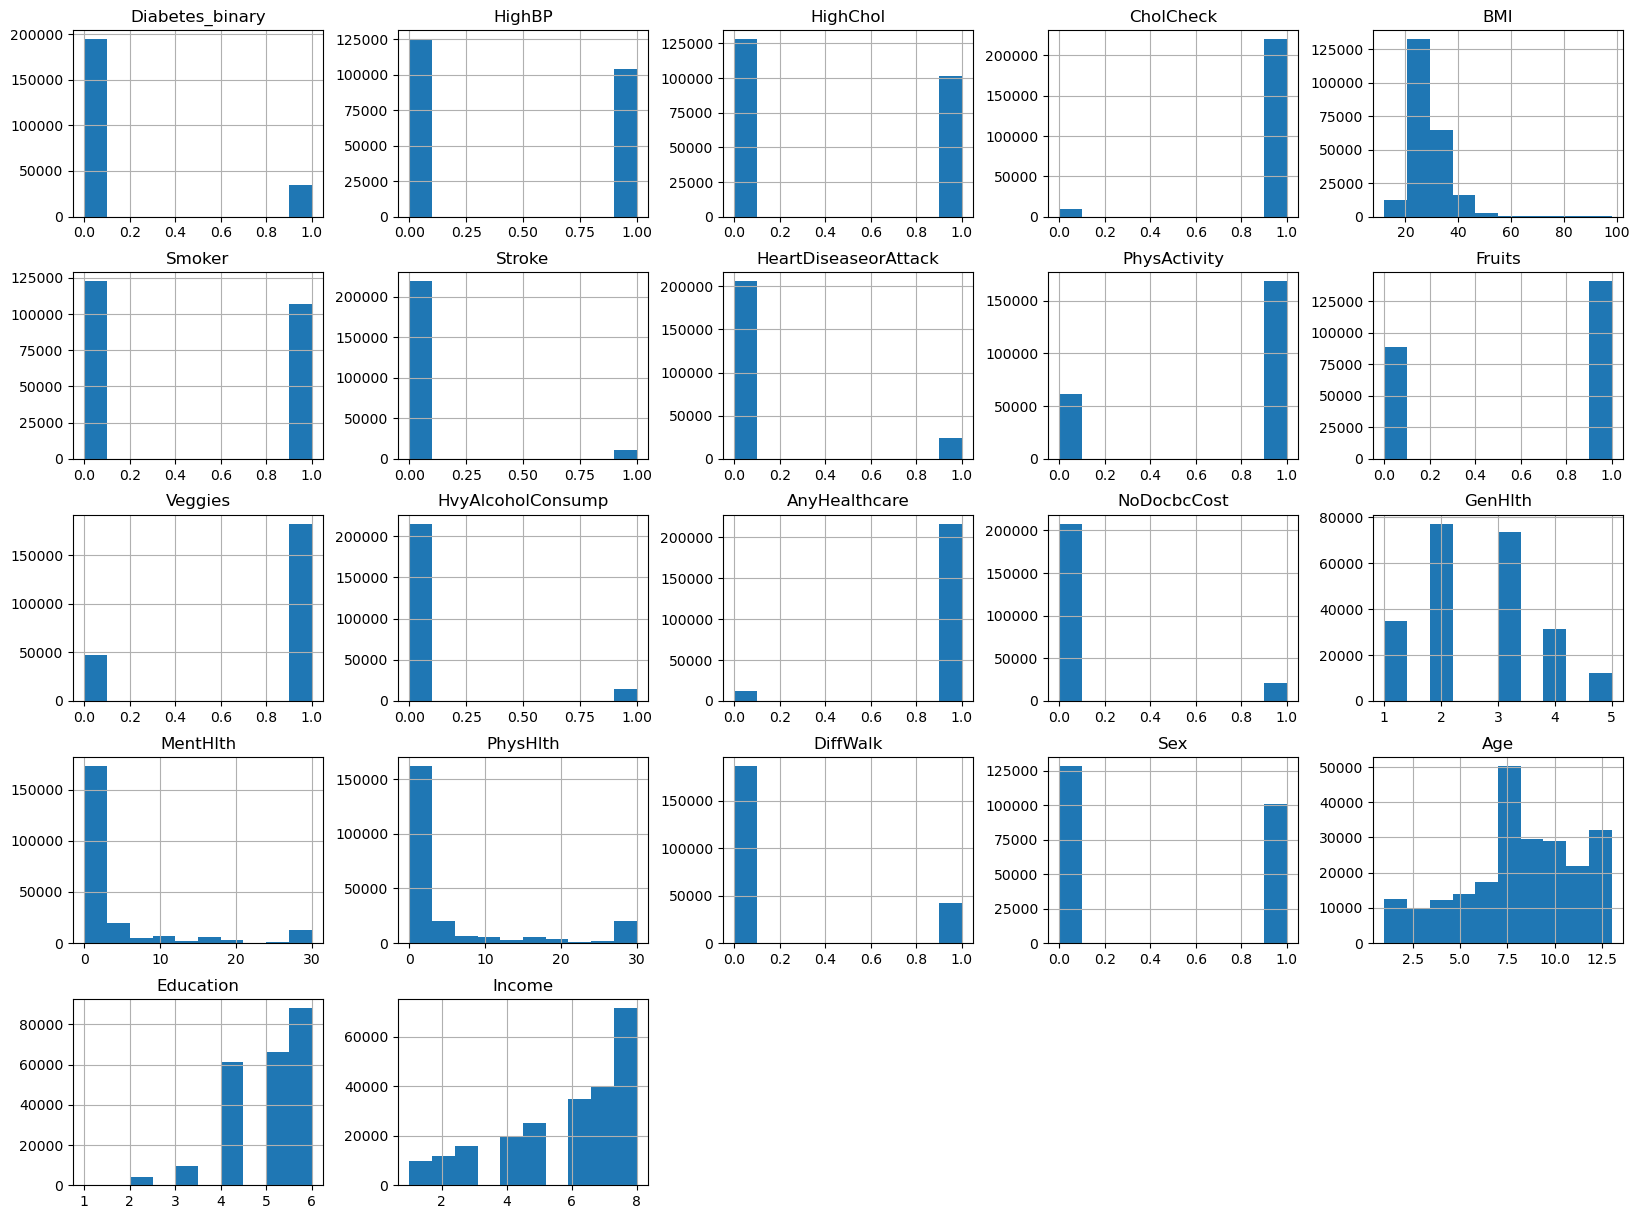

In [15]:
#using histogram to understand dataset df1 better

df1.hist(figsize=(20,15));

In [16]:
#checking correlation between columns of dataset df1

df1.corr()

Diabetes_binary    HighBP  HighChol  CholCheck  \
Diabetes_binary              1.000000  0.254318  0.194944   0.072523   
HighBP                       0.254318  1.000000  0.283963   0.111259   
HighChol                     0.194944  0.283963  1.000000   0.094772   
CholCheck                    0.072523  0.111259  0.094772   1.000000   
BMI                          0.205086  0.194218  0.089734   0.042487   
Smoker                       0.045504  0.074264  0.074583  -0.003721   
Stroke                       0.099193  0.124558  0.089375   0.027955   
HeartDiseaseorAttack         0.168213  0.201443  0.176446   0.050086   
PhysActivity                -0.100404 -0.104382 -0.063443  -0.004555   
Fruits                      -0.024805 -0.019467 -0.026257   0.017860   
Veggies                     -0.041734 -0.042994 -0.027399  -0.000653   
HvyAlcoholConsump           -0.065950 -0.014178 -0.019057  -0.020975   
AnyHealthcare                0.025331  0.052044  0.052363   0.115498   
NoDocbcCost                  0.020048  0.002292  0.003020  -0.054128   
GenHlth                      0.276940  0.272784  0.188139   0.062939   
MentHlth                     0.054153  0.037482  0.050346  -0.001430   
PhysHlth                     0.156211  0.144656  0.111008   0.040758   
DiffWalk                     0.205302  0.211759  0.136045   0.049107   
Sex                          0.032724  0.047119  0.022859  -0.024332   
Age                          0.177263  0.339802  0.263841   0.095942   
Education                   -0.102686 -0.112887 -0.050045  -0.009935   
Income                      -0.140659 -0.140030 -0.062089   0.001989   

                           BMI    Smoker    Stroke  HeartDiseaseorAttack  \
Diabetes_binary       0.205086  0.045504  0.099193              0.168213   
HighBP                0.194218  0.074264  0.124558              0.201443   
HighChol              0.089734  0.074583  0.089375              0.176446   
CholCheck             0.042487 -0.003721  0.027955              0.050086   
BMI                   1.000000 -0.009294  0.011006              0.039820   
Smoker               -0.009294  1.000000  0.054414              0.105169   
Stroke                0.011006  0.054414  1.000000              0.198814   
HeartDiseaseorAttack  0.039820  0.105169  0.198814              1.000000   
PhysActivity         -0.127780 -0.066869 -0.059306             -0.073094   
Fruits               -0.067424 -0.061731 -0.004486             -0.006946   
Veggies              -0.044054 -0.013744 -0.033029             -0.027180   
HvyAlcoholConsump    -0.058420  0.096048 -0.021347             -0.035561   
AnyHealthcare        -0.008519 -0.013963  0.013627              0.025987   
NoDocbcCost           0.045795  0.037335  0.028613              0.021971   
GenHlth               0.208351  0.134894  0.169809              0.246328   
MentHlth              0.068569  0.077641  0.061996              0.052601   
PhysHlth              0.102768  0.100447  0.140806              0.170335   
DiffWalk              0.182556  0.108144  0.169339              0.202657   
Sex                   0.030902  0.096650  0.003626              0.089828   
Age                  -0.049223  0.107695  0.128209              0.223912   
Education            -0.074433 -0.135657 -0.064178             -0.082288   
Income               -0.069097 -0.095314 -0.117108             -0.122728   

                      PhysActivity    Fruits   Veggies  HvyAlcoholConsump  \
Diabetes_binary          -0.100404 -0.024805 -0.041734          -0.065950   
HighBP                   -0.104382 -0.019467 -0.042994          -0.014178   
HighChol                 -0.063443 -0.026257 -0.027399          -0.019057   
CholCheck                -0.004555  0.017860 -0.000653          -0.020975   
BMI                      -0.127780 -0.067424 -0.044054          -0.058420   
Smoker                   -0.066869 -0.061731 -0.013744           0.096048   
Stroke                   -0.059306 -0.004486 -0.033029          -0.021347   


Text(0.5, 1.0, 'correlation of feature')

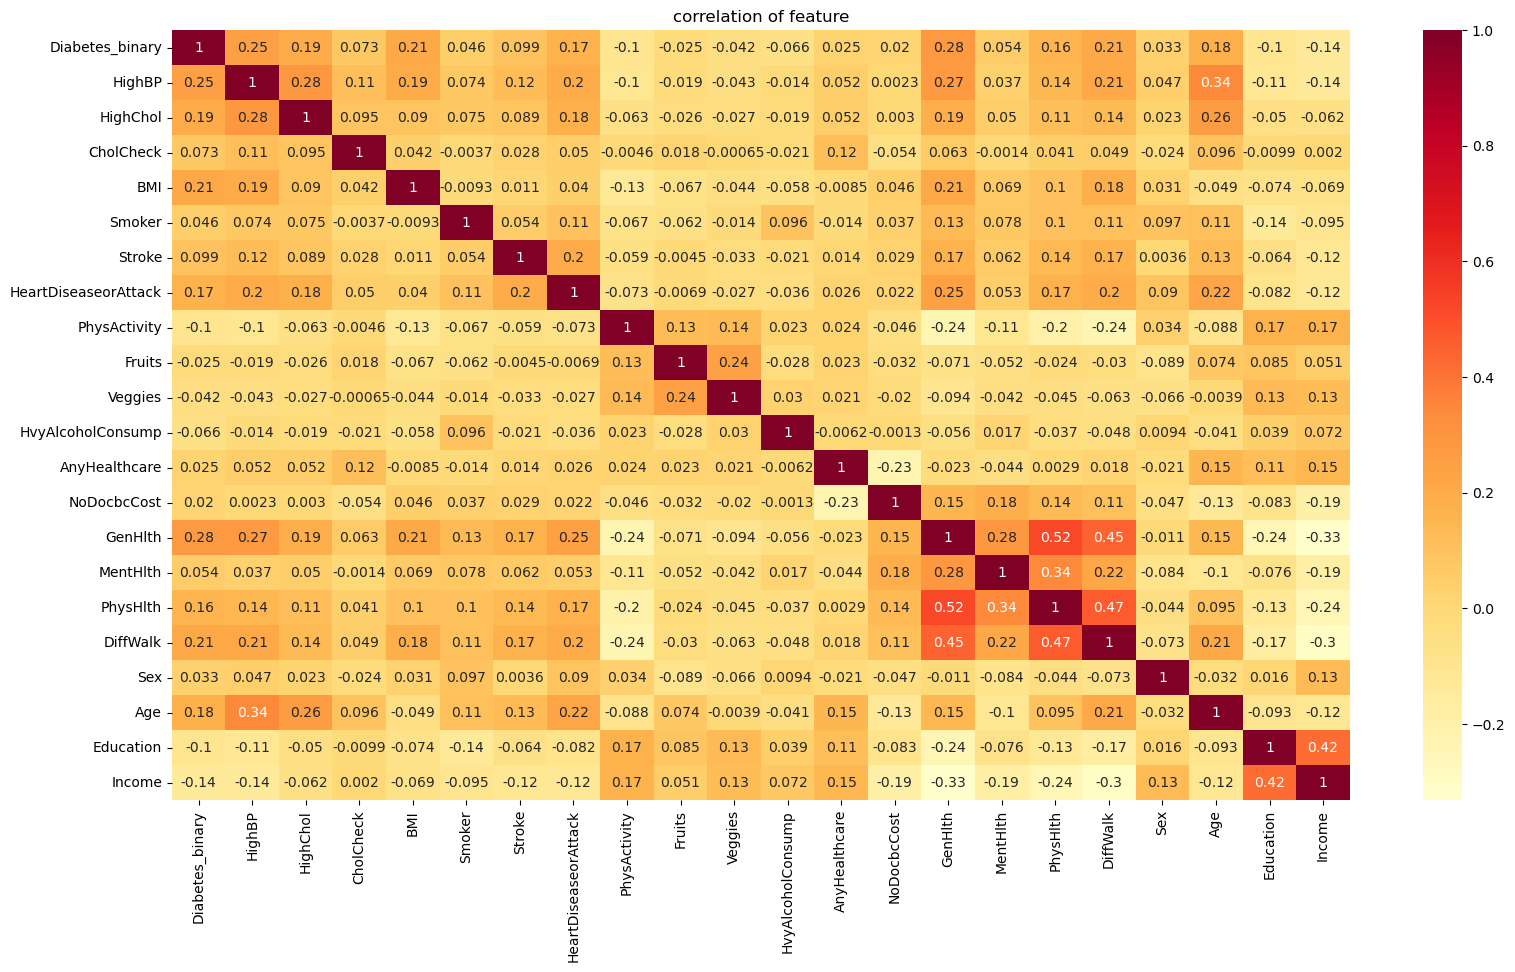

In [17]:
#using heatmap to understand correlation better in dataset df1
#Heatmap of correlation


plt.figure(figsize = (19,10))
sns.heatmap(df1.corr(),annot=True , cmap ='YlOrRd' )
plt.title("correlation of feature")

In [18]:
#Replacing 0 into Non-Diabetic and 1 into Diabetic
#adding new column Diabetes_binary_str

df1["Diabetes_binary_str"]= df1["Diabetes_binary"].replace({0:"NOn-Diabetic",1:"Diabetic"})

In [19]:
#average of column Daibetes_binary
# 0 for non-Diabetic person and 1 for Diabetic person

df1["Diabetes_binary_str"].value_counts()

NOn-Diabetic    194377
Diabetic         35097
Name: Diabetes_binary_str, dtype: int64

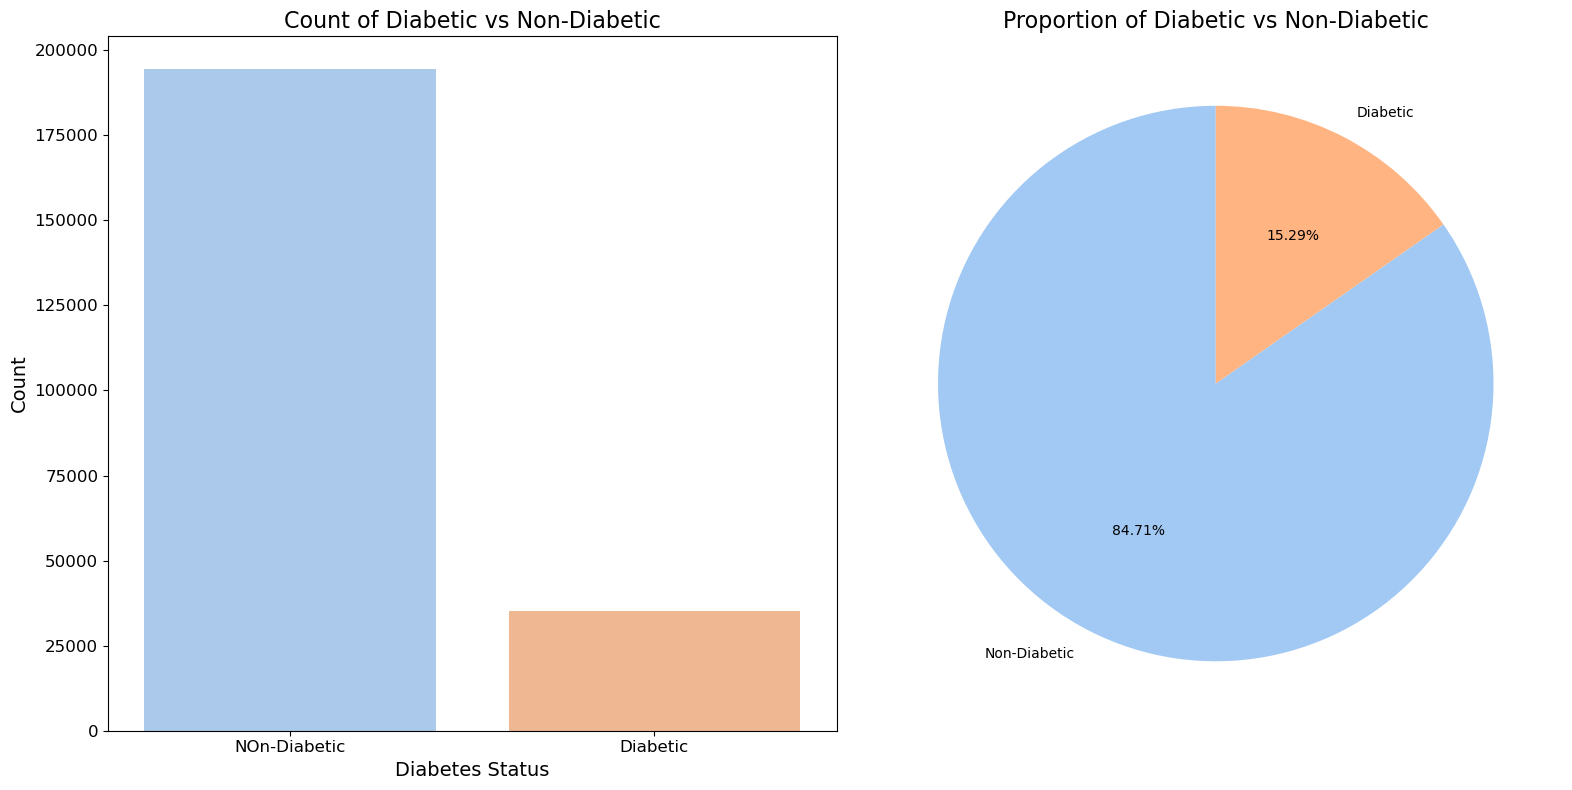

In [20]:
# Suppress warnings
warnings.filterwarnings('ignore')

# Create a figure with subplots
figure1, plot1 = plt.subplots(1, 2, figsize=(16, 8))

# Customize color palette
colors = sns.color_palette('pastel')

# Count plot for Diabetes_binary_str
sns.countplot(x='Diabetes_binary_str', data=df1, ax=plot1[0], palette=colors)
plot1[0].set_title('Count of Diabetic vs Non-Diabetic', fontsize=16)
plot1[0].set_xlabel('Diabetes Status', fontsize=14)
plot1[0].set_ylabel('Count', fontsize=14)
plot1[0].tick_params(axis='x', labelsize=12)
plot1[0].tick_params(axis='y', labelsize=12)

# Pie chart for the average of diabetic and non-diabetic people
labels = ["Non-Diabetic", "Diabetic"]
plot1[1].pie(df1["Diabetes_binary"].value_counts(), labels=labels, autopct='%.2f%%', startangle=90, colors=colors)
plot1[1].set_title('Proportion of Diabetic vs Non-Diabetic', fontsize=16)

# Improve layout
plt.tight_layout()

# Display the plots
plt.show()


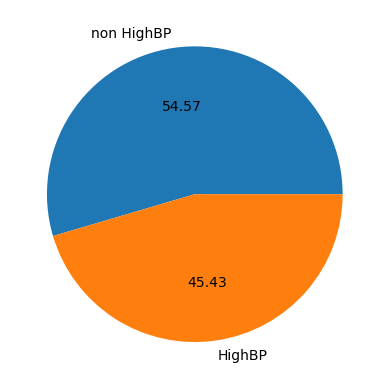

In [21]:
#checking HighBP and non HighBP pepoles average by pie

labels=["non HighBP","HighBP"]

plt.pie(df1["HighBP"].value_counts() , labels =labels ,autopct='%.02f' );

In [22]:
#number of Diabetic patient with HighBP

pd.crosstab(df1.HighBP,df1.Diabetes_binary_str)

Diabetes_binary_str  Diabetic  NOn-Diabetic
HighBP                                     
0.0                      8692        116522
1.0                     26405         77855

In [23]:
# checking average of diabetic persons with HighBP and NO HighBP


(df1.groupby("Diabetes_binary_str")["HighBP"].value_counts()/df1.groupby("Diabetes_binary_str")["HighBP"].count())*100

Diabetes_binary_str  HighBP
Diabetic             1.0       75.234351
                     0.0       24.765649
NOn-Diabetic         0.0       59.946393
                     1.0       40.053607
Name: HighBP, dtype: float64

In [24]:
#checking BMI values

ax= px.treemap(df1,path=['BMI'],title="BMI counts")
ax.show()

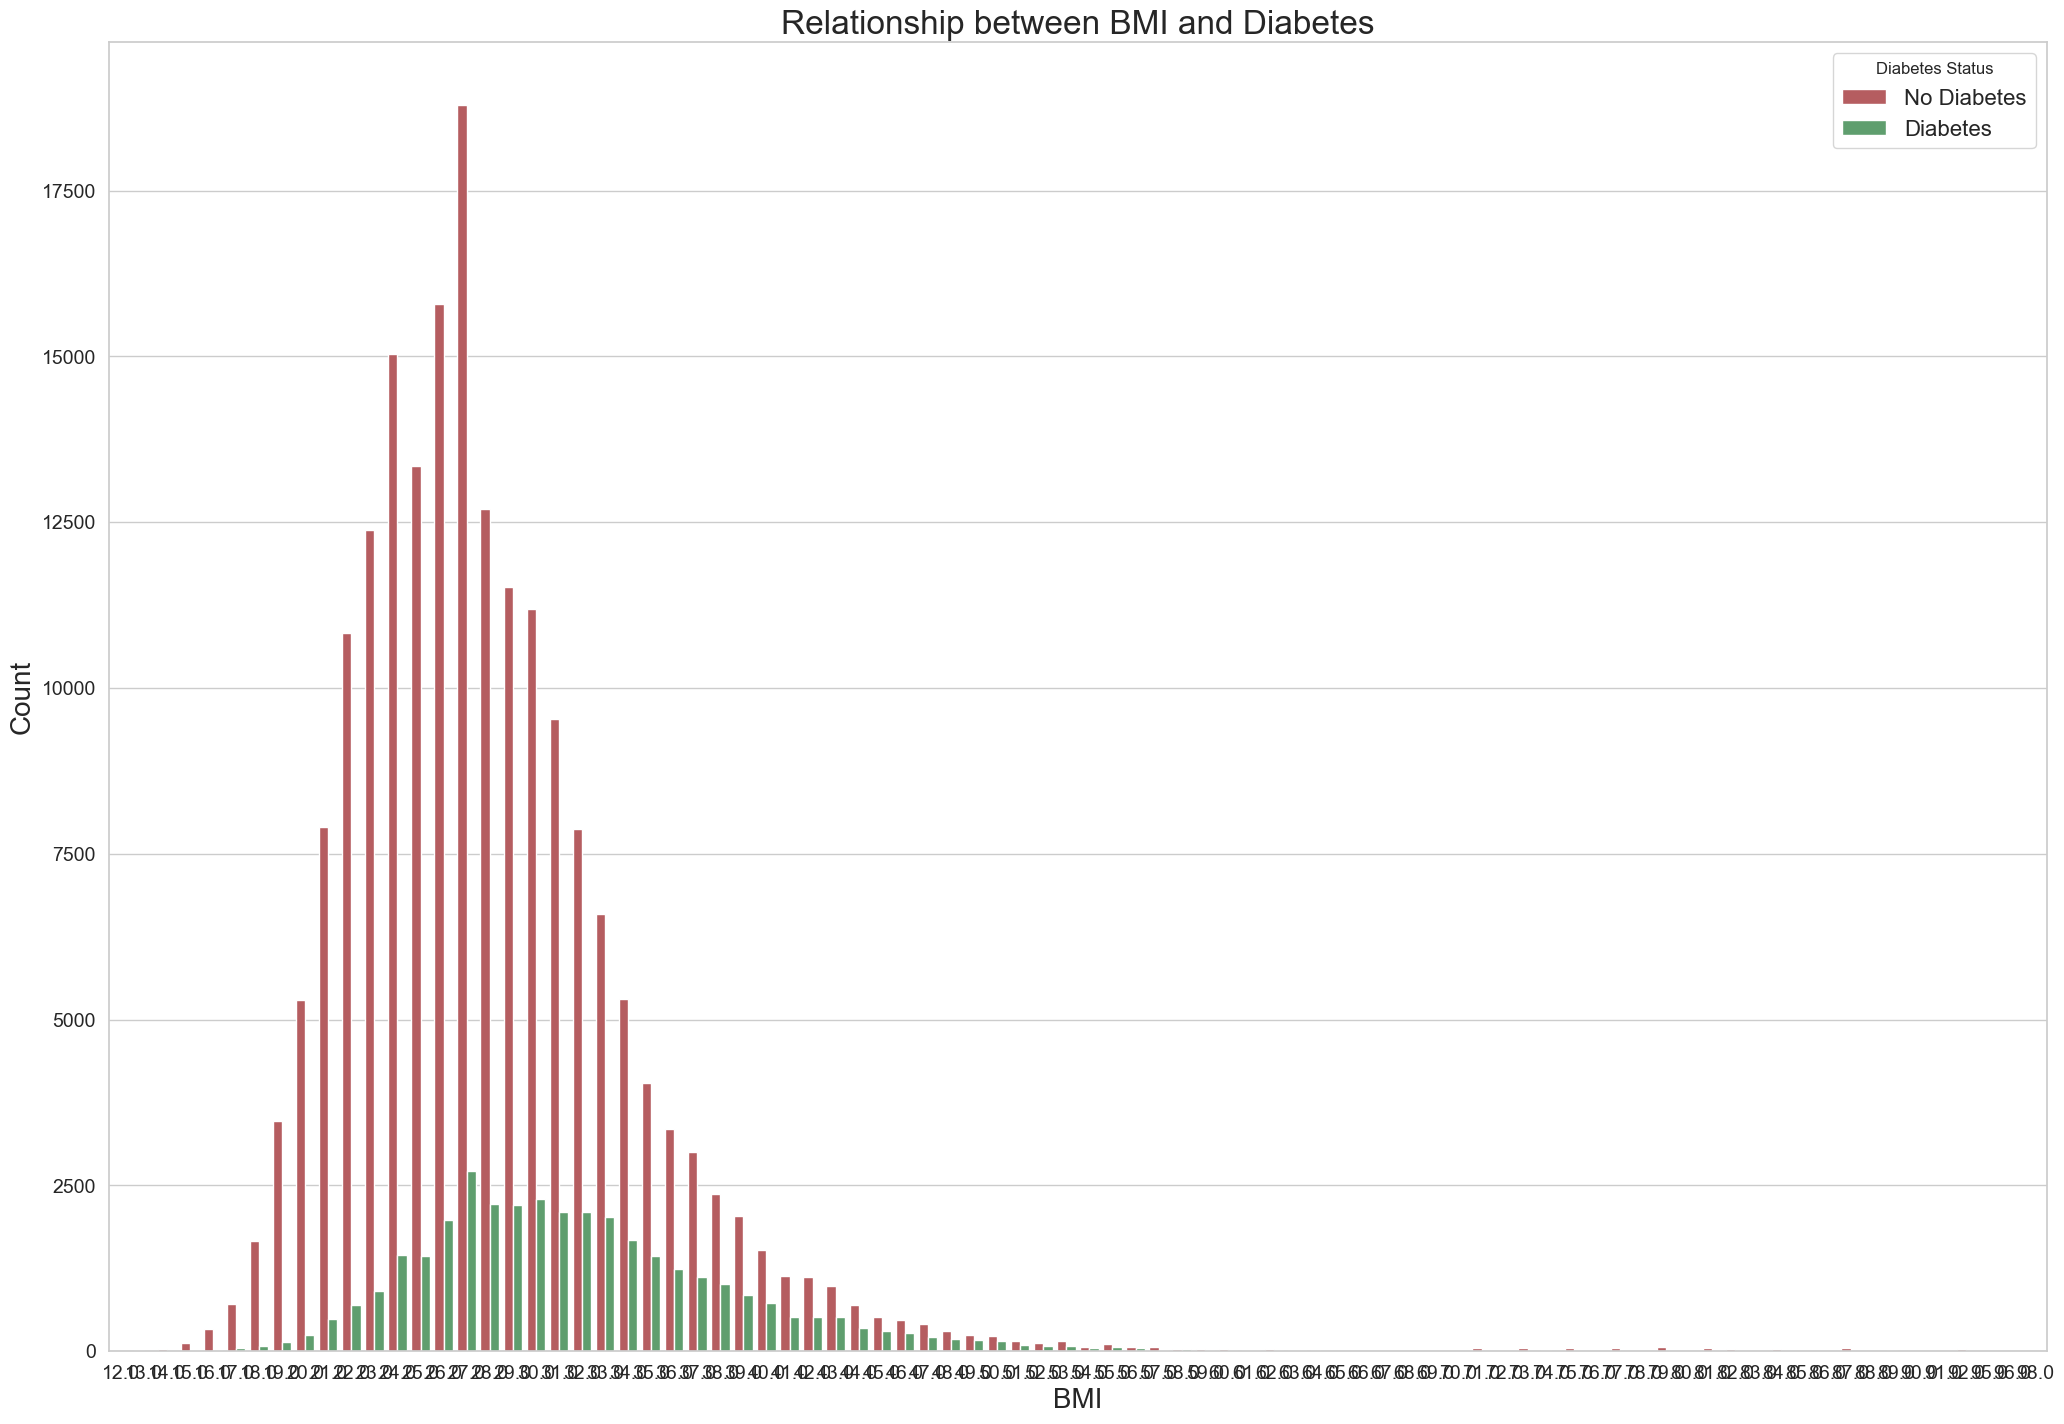

In [25]:
# Suppress warnings
warnings.filterwarnings('ignore')

# Set the style and context for the plot
sns.set(style="whitegrid")
plt.figure(figsize=(25, 17))

# Plot the BMI countplot for both categories
sns.countplot(x='BMI', hue='Diabetes_binary', data=df1, palette=["r", "g"])

# Add titles and labels
plt.title("Relationship between BMI and Diabetes", fontsize=24)
plt.xlabel("BMI", fontsize=20)
plt.ylabel("Count", fontsize=20)
plt.legend(title='Diabetes Status', labels=["No Diabetes", "Diabetes"], fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# Show the plot
plt.show()


<Axes: >

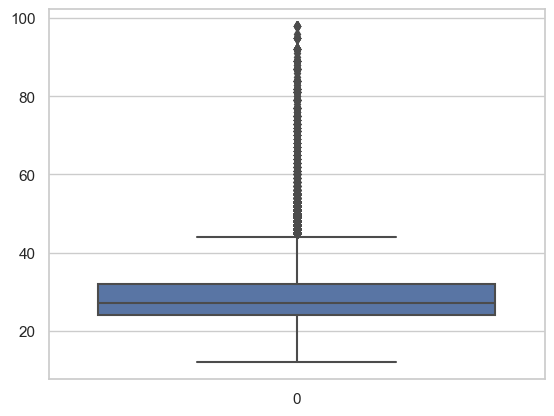

In [26]:
# checking the outliers in BMI continuous feature

sns.boxplot(df1["BMI"])

In [27]:
#checking Diabetic patient with BMI less than 20

df1[(df1["BMI"]<=20)]["Diabetes_binary"].value_counts()

0.0    11650
1.0      545
Name: Diabetes_binary, dtype: int64

In [28]:
#seconed groups BMI is greater than 20 and less than equal to 50

BMI_2 = df1.iloc[np.where((df1["BMI"]>20)&(df1["BMI"]<=50))]

print("len of BMI_2 : ", len(BMI_2))

BMI_2 = pd.DataFrame(BMI_2)

len of BMI_2 :  215104


In [29]:
#checking Diabetic patient with BMI (BMI>20 and BMI<=50)


df1[(df1["BMI"]>20) & (df1["BMI"]<=50)]["Diabetes_binary_str"].value_counts()

NOn-Diabetic    181255
Diabetic         33849
Name: Diabetes_binary_str, dtype: int64

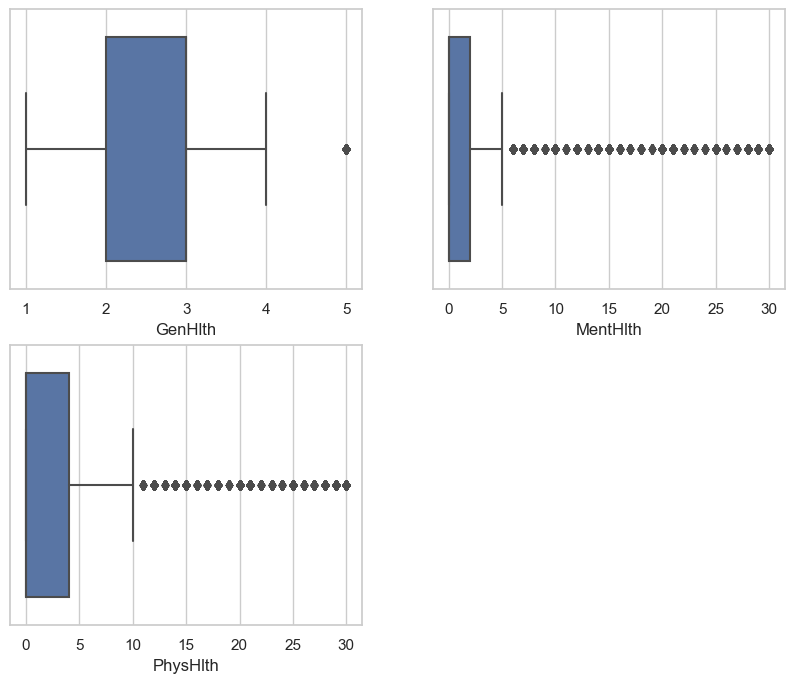

In [30]:
# checking outliers in ontinuous feature variable GenHlth , MentHlth and PhysHlth

plt.figure(figsize = (10,8))
for i,col in enumerate(['GenHlth', 'MentHlth', 'PhysHlth']):
    plt.subplot(2,2,i+1)
    sns.boxplot(x = col, data = df1)
plt.show()

# Preprocessing

## Handling Outliers

In [31]:
numeric_cols, categorical_cols = categorize_data(df1) #categorise data

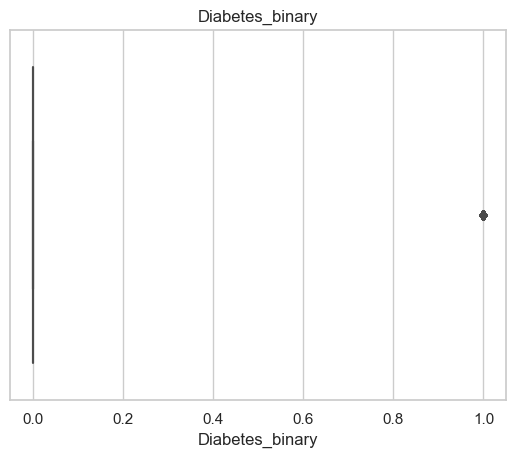

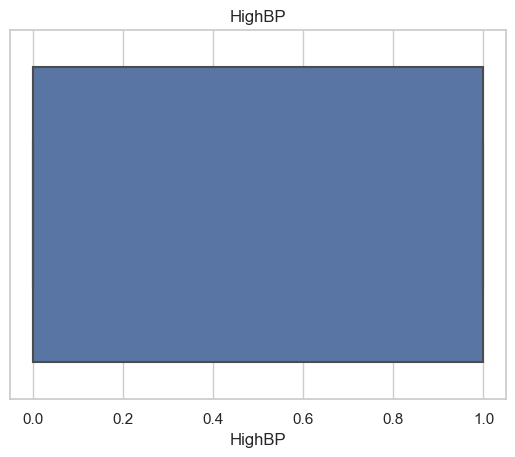

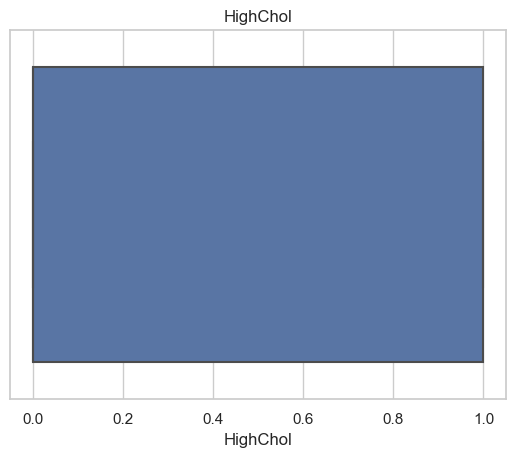

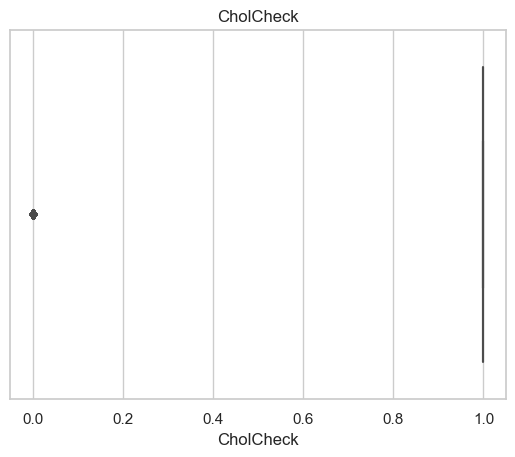

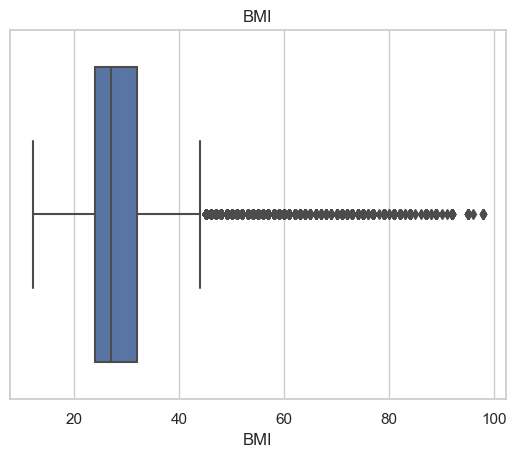

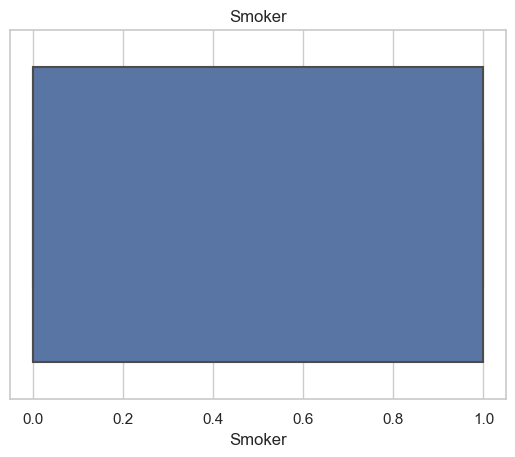

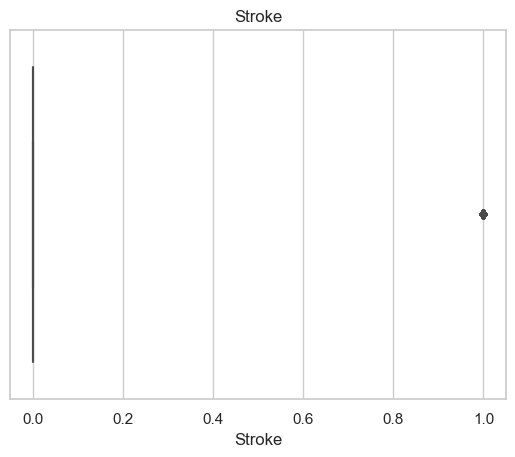

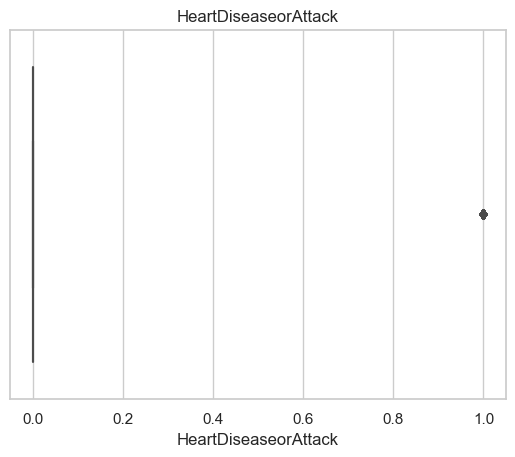

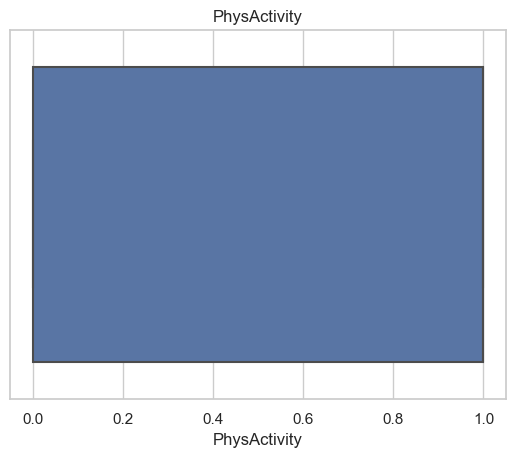

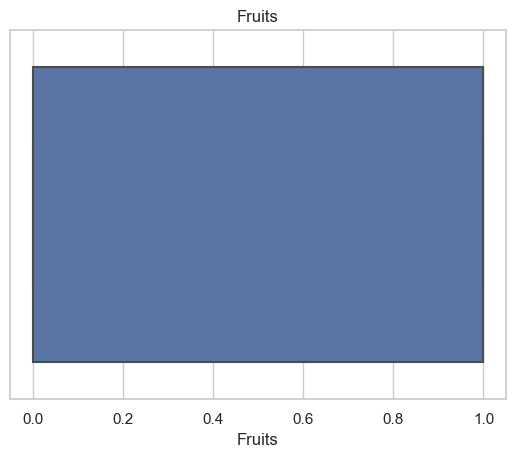

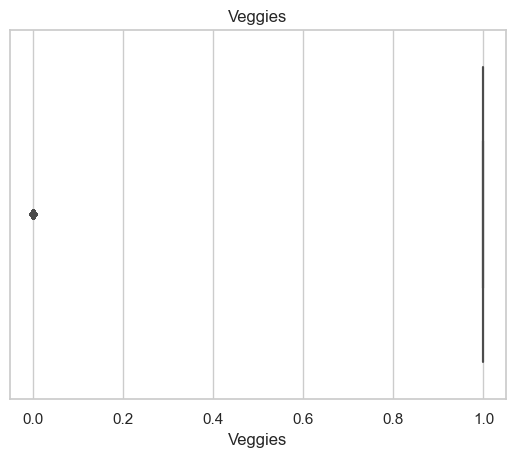

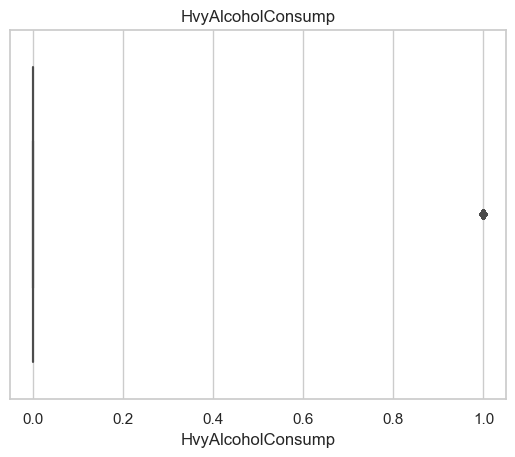

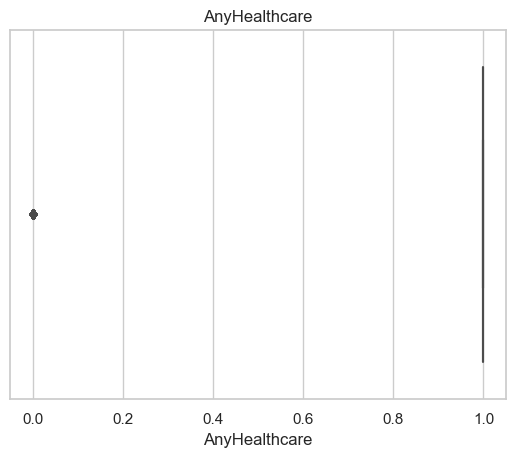

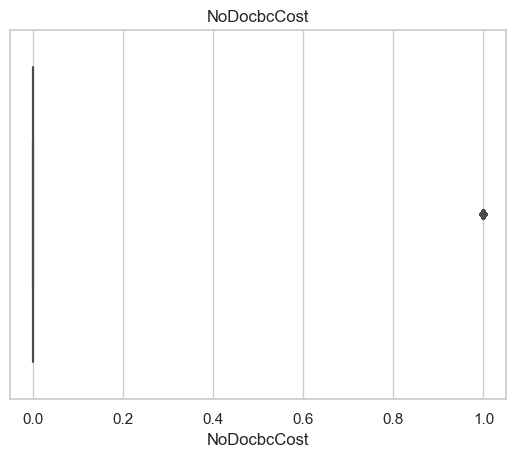

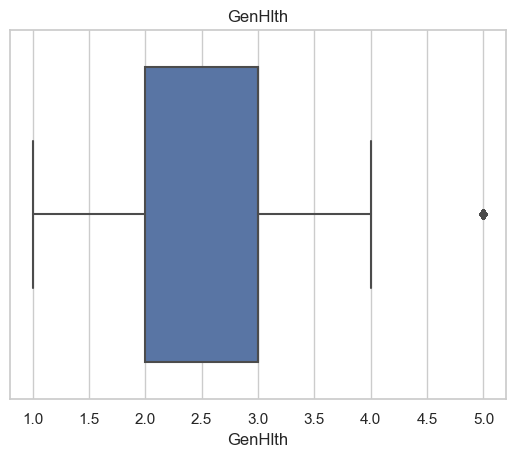

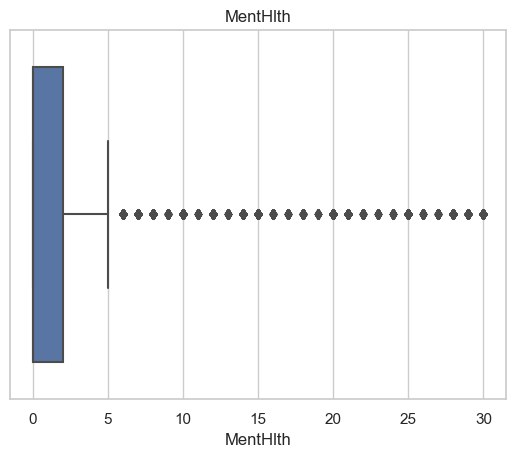

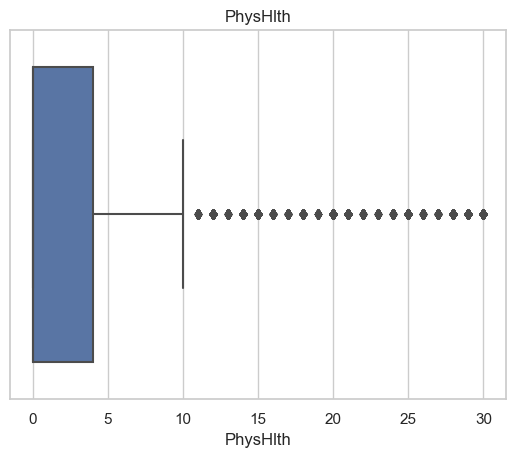

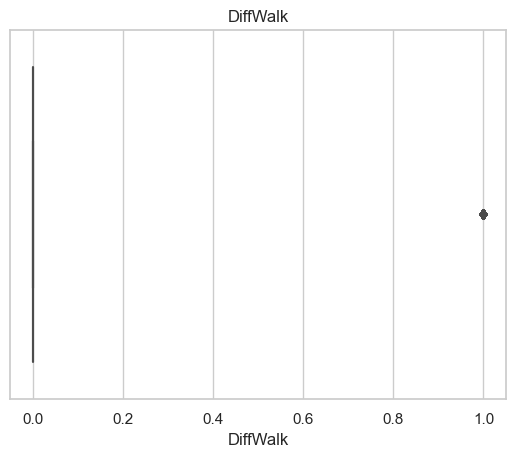

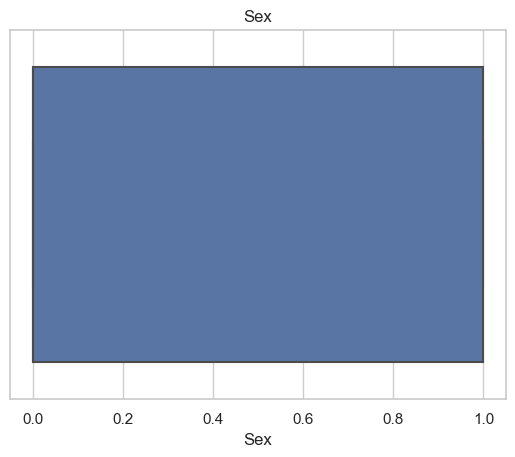

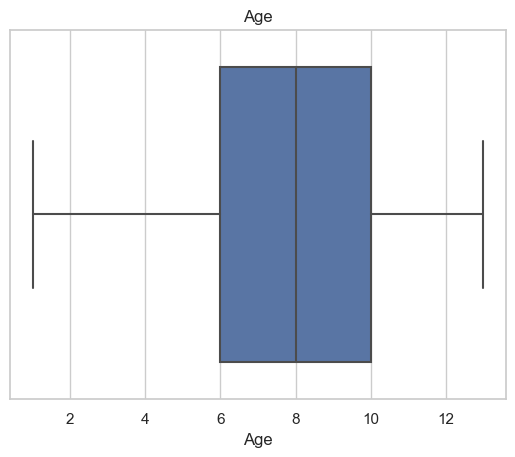

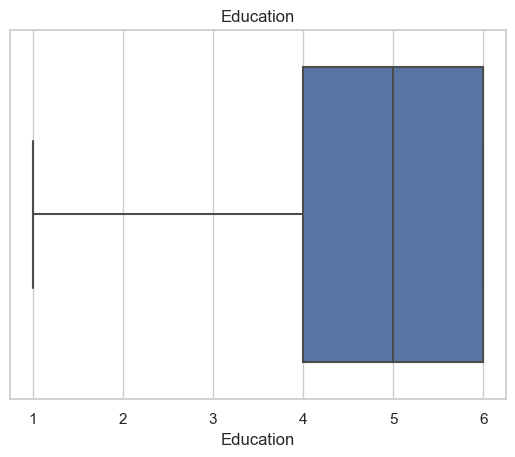

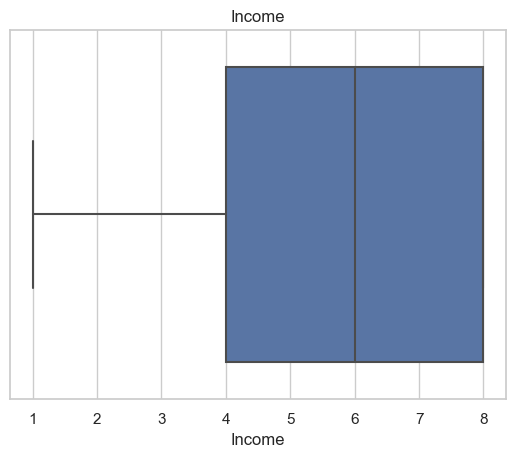

In [32]:
#Box plots for numeric columns
for i in range (len(numeric_cols)):
    plt.figure()
    plt.title(numeric_cols[i])
    sns.boxplot(x=df1[numeric_cols[i]], data=df1)

In [33]:
# More insights into outliers
outliers = outliers_check(df1, numeric_cols)

Diabetes_binary  35097
HighBP  0
HighChol  0
CholCheck  9298
BMI  5638
Smoker  0
Stroke  10284
HeartDiseaseorAttack  23713
PhysActivity  0
Fruits  0
Veggies  47137
HvyAlcoholConsump  13950
AnyHealthcare  12389
NoDocbcCost  21323
GenHlth  12078
MentHlth  36162
PhysHlth  34346
DiffWalk  42625
Sex  0
Age  0
Education  0
Income  0


In [34]:
#remove outliers
removed_outliers=remove_outliers(df1, ['MentHlth', 'PhysHlth'])
(removed_outliers)

Diabetes_binary  HighBP  HighChol  CholCheck   BMI  Smoker  Stroke  \
0                   0.0     1.0       1.0        1.0  40.0     1.0     0.0   
1                   0.0     0.0       0.0        0.0  25.0     1.0     0.0   
2                   0.0     1.0       1.0        1.0  28.0     0.0     0.0   
3                   0.0     1.0       0.0        1.0  27.0     0.0     0.0   
4                   0.0     1.0       1.0        1.0  24.0     0.0     0.0   
...                 ...     ...       ...        ...   ...     ...     ...   
253675              0.0     1.0       1.0        1.0  45.0     0.0     0.0   
253676              1.0     1.0       1.0        1.0  18.0     0.0     0.0   
253677              0.0     0.0       0.0        1.0  28.0     0.0     0.0   
253678              0.0     1.0       0.0        1.0  23.0     0.0     0.0   
253679              1.0     1.0       1.0        1.0  25.0     0.0     0.0   

        HeartDiseaseorAttack  PhysActivity  Fruits  Veggies  \
0                        0.0           0.0     0.0      1.0   
1                        0.0           1.0     0.0      0.0   
2                        0.0           0.0     1.0      0.0   
3                        0.0           1.0     1.0      1.0   
4                        0.0           1.0     1.0      1.0   
...                      ...           ...     ...      ...   
253675                   0.0           0.0     1.0      1.0   
253676                   0.0           0.0     0.0      0.0   
253677                   0.0           1.0     1.0      0.0   
253678                   0.0           0.0     1.0      1.0   
253679                   1.0           1.0     1.0      0.0   

        HvyAlcoholConsump  AnyHealthcare  NoDocbcCost  GenHlth  MentHlth  \
0                     0.0            1.0          0.0      5.0       0.0   
1                     0.0            0.0          1.0      3.0       0.0   
2                     0.0            1.0          1.0      5.0       0.0   
3                     0.0            1.0          0.0      2.0       0.0   
4                     0.0            1.0          0.0      2.0       3.0   
...                   ...            ...          ...      ...       ...   
253675                0.0            1.0          0.0      3.0       0.0   
253676                0.0            1.0          0.0      4.0       0.0   
253677                0.0            1.0          0.0      1.0       0.0   
253678                0.0            1.0          0.0      3.0       0.0   
253679                0.0            1.0          0.0      2.0       0.0   

        PhysHlth  DiffWalk  Sex   Age  Education  Income Diabetes_binary_str  
0            0.0       1.0  0.0   9.0        4.0     3.0        NOn-Diabetic  
1            0.0       0.0  0.0   7.0        6.0     1.0        NOn-Diabetic  
2            0.0       1.0  0.0   9.0        4.0     8.0        NOn-Diabetic  
3            0.0       0.0  0.0  11.0        3.0     6.0        NOn-Diabetic  
4            0.0       0.0  0.0  11.0        5.0     4.0        NOn-Diabetic  
...          ...       ...  ...   ...        ...     ...                 ...  
253675       5.0       0.0  1.0   5.0        6.0     7.0        NOn-Diabetic  
253676       0.0       1.0  0.0  11.0        2.0     4.0            Diabetic  
253677       0.0       0.0  0.0   2.0        5.0     2.0        NOn-Diabetic  
253678       0.0       0.0  1.0   7.0        5.0     1.0        NOn-Diabetic  
253679       0.0       0.0  0.0   9.0        6.0     2.0            Diabetic  

[229474 rows x 23 columns]

In [35]:
data_before_split = removed_outliers.drop("Diabetes_binary_str", axis=1) #drop Diabetes_binary_str column

In [36]:
data_before_split

Diabetes_binary  HighBP  HighChol  CholCheck   BMI  Smoker  Stroke  \
0                   0.0     1.0       1.0        1.0  40.0     1.0     0.0   
1                   0.0     0.0       0.0        0.0  25.0     1.0     0.0   
2                   0.0     1.0       1.0        1.0  28.0     0.0     0.0   
3                   0.0     1.0       0.0        1.0  27.0     0.0     0.0   
4                   0.0     1.0       1.0        1.0  24.0     0.0     0.0   
...                 ...     ...       ...        ...   ...     ...     ...   
253675              0.0     1.0       1.0        1.0  45.0     0.0     0.0   
253676              1.0     1.0       1.0        1.0  18.0     0.0     0.0   
253677              0.0     0.0       0.0        1.0  28.0     0.0     0.0   
253678              0.0     1.0       0.0        1.0  23.0     0.0     0.0   
253679              1.0     1.0       1.0        1.0  25.0     0.0     0.0   

        HeartDiseaseorAttack  PhysActivity  Fruits  Veggies  \
0                        0.0           0.0     0.0      1.0   
1                        0.0           1.0     0.0      0.0   
2                        0.0           0.0     1.0      0.0   
3                        0.0           1.0     1.0      1.0   
4                        0.0           1.0     1.0      1.0   
...                      ...           ...     ...      ...   
253675                   0.0           0.0     1.0      1.0   
253676                   0.0           0.0     0.0      0.0   
253677                   0.0           1.0     1.0      0.0   
253678                   0.0           0.0     1.0      1.0   
253679                   1.0           1.0     1.0      0.0   

        HvyAlcoholConsump  AnyHealthcare  NoDocbcCost  GenHlth  MentHlth  \
0                     0.0            1.0          0.0      5.0       0.0   
1                     0.0            0.0          1.0      3.0       0.0   
2                     0.0            1.0          1.0      5.0       0.0   
3                     0.0            1.0          0.0      2.0       0.0   
4                     0.0            1.0          0.0      2.0       3.0   
...                   ...            ...          ...      ...       ...   
253675                0.0            1.0          0.0      3.0       0.0   
253676                0.0            1.0          0.0      4.0       0.0   
253677                0.0            1.0          0.0      1.0       0.0   
253678                0.0            1.0          0.0      3.0       0.0   
253679                0.0            1.0          0.0      2.0       0.0   

        PhysHlth  DiffWalk  Sex   Age  Education  Income  
0            0.0       1.0  0.0   9.0        4.0     3.0  
1            0.0       0.0  0.0   7.0        6.0     1.0  
2            0.0       1.0  0.0   9.0        4.0     8.0  
3            0.0       0.0  0.0  11.0        3.0     6.0  
4            0.0       0.0  0.0  11.0        5.0     4.0  
...          ...       ...  ...   ...        ...     ...  
253675       5.0       0.0  1.0   5.0        6.0     7.0  
253676       0.0       1.0  0.0  11.0        2.0     4.0  
253677       0.0       0.0  0.0   2.0        5.0     2.0  
253678       0.0       0.0  1.0   7.0        5.0     1.0  
253679       0.0       0.0  0.0   9.0        6.0     2.0  

[229474 rows x 22 columns]

In [37]:
#Randomise the dataset

data_randomized = data_before_split.sample(n=15000, random_state=42)

#All features except the target are assigned to 'X'
#categorical_cols.remove('deposit')
X = data_randomized.drop("Diabetes_binary", axis=1)

#Target feature is assigned to 'Y'
Y = data_randomized["Diabetes_binary"]

X.head()

HighBP  HighChol  CholCheck   BMI  Smoker  Stroke  \
218137     0.0       0.0        1.0  24.0     0.0     0.0   
234092     0.0       0.0        1.0  22.0     0.0     0.0   
220499     0.0       0.0        1.0  25.0     0.0     0.0   
133305     1.0       1.0        1.0  24.0     1.0     0.0   
1394       0.0       1.0        1.0  28.0     0.0     0.0   

        HeartDiseaseorAttack  PhysActivity  Fruits  Veggies  \
218137                   0.0           1.0     1.0      1.0   
234092                   0.0           1.0     1.0      1.0   
220499                   0.0           1.0     1.0      1.0   
133305                   1.0           0.0     0.0      0.0   
1394                     0.0           0.0     0.0      0.0   

        HvyAlcoholConsump  AnyHealthcare  NoDocbcCost  GenHlth  MentHlth  \
218137                0.0            1.0          0.0      2.0       2.0   
234092                0.0            1.0          0.0      1.0       0.0   
220499                0.0            1.0          0.0      2.0       0.0   
133305                0.0            1.0          0.0      5.0       0.0   
1394                  0.0            1.0          0.0      3.0       0.0   

        PhysHlth  DiffWalk  Sex   Age  Education  Income  
218137      10.0       0.0  0.0  10.0        6.0     8.0  
234092       0.0       0.0  0.0  13.0        5.0     4.0  
220499       0.0       0.0  1.0  10.0        4.0     4.0  
133305       0.0       1.0  0.0  10.0        3.0     1.0  
1394         0.0       0.0  0.0  12.0        3.0     2.0

## Rebalancing

In [38]:
#split into train and test, then perform rebalancing on taining data

x, xtest, y, ytest = train_test_split(X, Y, test_size=0.2, random_state=None)
xtrain, xval, ytrain, yval = train_test_split(x, y, test_size=0.3, random_state=None)

In [39]:
Y.value_counts()

0.0    12639
1.0     2361
Name: Diabetes_binary, dtype: int64

In [40]:
#Undersampling

undersampling = RandomUnderSampler(random_state=42)

xtrain_undersampled, ytrain_undersampled = undersampling.fit_resample(xtrain, ytrain)

xtrain_undersampled.shape

(2682, 21)

In [41]:
#Oversampling

oversampling = RandomOverSampler(random_state=42)

xtrain_oversampled, ytrain_oversampled = oversampling.fit_resample(xtrain, ytrain)

xtrain_oversampled.shape

(14118, 21)

In [42]:
#data is now balanced

print("Undersampled:\n", ytrain_undersampled.value_counts())

print("\nOversampled:\n", ytrain_oversampled.value_counts())

Undersampled:
 0.0    1341
1.0    1341
Name: Diabetes_binary, dtype: int64

Oversampled:
 0.0    7059
1.0    7059
Name: Diabetes_binary, dtype: int64


## Scaling

In [43]:
#Scaling the data - oversampled dataset & undersampled

cols_to_scale = ["BMI", "Age"]

#transform data
scaler = StandardScaler()
xtrain_oversampled[cols_to_scale] = scaler.fit_transform(xtrain_oversampled[cols_to_scale])
xtrain_undersampled[cols_to_scale] = scaler.fit_transform(xtrain_undersampled[cols_to_scale])


xtest[cols_to_scale] = scaler.transform(xtest[cols_to_scale])
xval[cols_to_scale] = scaler.transform(xval[cols_to_scale])



xtrain_oversampled.shape

(14118, 21)

In [44]:
xtrain_oversampled

HighBP  HighChol  CholCheck       BMI  Smoker  Stroke  \
0         0.0       0.0        0.0 -1.812435     1.0     0.0   
1         0.0       0.0        1.0 -0.968746     0.0     0.0   
2         1.0       1.0        1.0  1.421705     0.0     0.0   
3         1.0       1.0        1.0 -0.968746     1.0     0.0   
4         0.0       0.0        1.0 -0.406287     1.0     0.0   
...       ...       ...        ...       ...     ...     ...   
14113     0.0       1.0        1.0  0.156172     1.0     0.0   
14114     0.0       0.0        1.0  0.578017     0.0     0.0   
14115     1.0       1.0        1.0  0.015557     0.0     0.0   
14116     0.0       0.0        1.0  0.296787     0.0     0.0   
14117     1.0       1.0        1.0 -0.968746     1.0     0.0   

       HeartDiseaseorAttack  PhysActivity  Fruits  Veggies  HvyAlcoholConsump  \
0                       0.0           0.0     1.0      1.0                0.0   
1                       0.0           0.0     0.0      1.0                0.0   
2                       0.0           0.0     0.0      1.0                0.0   
3                       0.0           1.0     0.0      0.0                0.0   
4                       0.0           1.0     0.0      1.0                0.0   
...                     ...           ...     ...      ...                ...   
14113                   1.0           1.0     0.0      1.0                0.0   
14114                   1.0           0.0     0.0      1.0                0.0   
14115                   0.0           1.0     1.0      1.0                0.0   
14116                   0.0           1.0     1.0      1.0                0.0   
14117                   0.0           1.0     0.0      0.0                0.0   

       AnyHealthcare  NoDocbcCost  GenHlth  MentHlth  PhysHlth  DiffWalk  Sex  \
0                1.0          0.0      1.0       4.0       3.0       0.0  1.0   
1                1.0          0.0      1.0       5.0       0.0       0.0  0.0   
2                1.0          0.0      3.0       0.0       0.0       0.0  0.0   
3                1.0          0.0      4.0       0.0       0.0       0.0  1.0   
4                1.0          0.0      2.0       2.0       0.0       0.0  0.0   
...              ...          ...      ...       ...       ...       ...  ...   
14113            1.0          0.0      3.0       5.0       0.0       0.0  1.0   
14114            1.0          0.0      4.0       5.0       0.0       1.0  1.0   
14115            1.0          0.0      3.0       0.0       3.0       0.0  0.0   
14116            1.0          0.0      2.0       0.0       2.0       1.0  0.0   
14117            1.0          0.0      4.0       0.0       0.0       0.0  1.0   

            Age  Education  Income  
0     -1.275270        6.0     3.0  
1     -0.924255        4.0     8.0  
2      0.479805        6.0     8.0  
3      1.532850        6.0     6.0  
4     -1.275270        5.0     8.0  
...         ...        ...     ...  
14113 -0.222225        4.0     7.0  
14114  0.479805        5.0     4.0  
14115  1.532850        6.0     2.0  
14116  0.479805        5.0     4.0  
14117  1.532850        6.0     6.0  

[14118 rows x 21 columns]

## Dimensionality Reduction: Principal Compoent Analysis (PCA)

In [45]:
num_components = len(xtrain.columns) - 4 #number of components to remove

In [46]:
#PCA - oversampled dataset

#Initialize PCA with the desired number of features (components). 4 features are removed making 17
pca_undersampled = PCA(n_components=num_components)

# Fit PCA on the training data
pca_undersampled.fit(xtrain_undersampled)

# Transform both the training and testing data
xtrain_pca_undersampled = pca_undersampled.transform(xtrain_undersampled)
xval_pca_undersampled = pca_undersampled.transform(xval)
xtest_pca_undersampled = pca_undersampled.transform(xtest)

In [47]:
#PCA - oversampled dataset

#Initialize PCA with the desired number of features (components). 4 features are removed making 17
pca = PCA(n_components=num_components)

# Fit PCA on the training data
pca.fit(xtrain_oversampled)

# Transform both training and testing data
xtrain_pca_oversampled = pca.transform(xtrain_oversampled)
xval_pca_oversampled = pca.transform(xval)
xtest_pca_oversampled = pca.transform(xtest)

print("Shape of xtrain_pca_undersampled:", xtrain_pca_oversampled.shape)
print("Shape of ytrain:", ytrain_oversampled.shape)


print("Unique labels in ytrain:", np.unique(ytrain))
print("Number of unique labels:", len(np.unique(ytrain)))

Shape of xtrain_pca_undersampled: (14118, 17)
Shape of ytrain: (14118,)
Unique labels in ytrain: [0. 1.]
Number of unique labels: 2


# Modelling

## Decision Tree

In [48]:
#List to hold models and data for result compilation

DT_models = []
DT_name = []
x_val_list = []
x_test_list = []

In [49]:
#hyperparameter
ccp_alpha = 0.05
txt = "ccp_alpha: 0.05"

In [50]:
#DecsionTree model - oversampled dataset

#Initialize the decision tree classifier
clf_oversampled = DecisionTreeClassifier(ccp_alpha=ccp_alpha)
DT_models.append(clf_oversampled)
DT_name.append(f"Oversampled dataset(No PCA), {txt}")
x_val_list.append(xval)
x_test_list.append(xtest)


# Fit the classifier to the training data
clf_oversampled.fit(xtrain_oversampled, ytrain_oversampled)

DecisionTreeClassifier(ccp_alpha=0.05)

In [51]:
#DecsionTree model - undersampled dataset

#Initialize the decision tree classifier
clf_undersampled = DecisionTreeClassifier(ccp_alpha=ccp_alpha)

DT_models.append(clf_undersampled)
DT_name.append(f"Undersampled dataset(No PCA),{txt}")
x_val_list.append(xval)
x_test_list.append(xtest)

# Fit the classifier to the training data
clf_undersampled.fit(xtrain_undersampled, ytrain_undersampled)

DecisionTreeClassifier(ccp_alpha=0.05)

In [52]:
#DecsionTree model - oversampled dataset

#Initialize the decision tree classifier
clf_oversampled_pca = DecisionTreeClassifier(ccp_alpha=ccp_alpha)

DT_models.append(clf_oversampled_pca)
DT_name.append(f"Oversampled dataset(PCA), {txt}")
x_val_list.append(xval_pca_oversampled)
x_test_list.append(xtest_pca_oversampled)

# Fit the classifier to the training data
clf_oversampled_pca.fit(xtrain_pca_oversampled, ytrain_oversampled)

DecisionTreeClassifier(ccp_alpha=0.05)

In [53]:
#DecsionTree model - undersampled dataset

#Initialize the decision tree classifier
clf_undersampled_pca = DecisionTreeClassifier(ccp_alpha=ccp_alpha)

DT_models.append(clf_undersampled_pca)
DT_name.append(f"Undersampled dataset(PCA), {txt}")
x_val_list.append(xval_pca_undersampled)
x_test_list.append(xtest_pca_undersampled)

# Fit the classifier to the training data
clf_undersampled_pca.fit(xtrain_pca_undersampled, ytrain_undersampled)

DecisionTreeClassifier(ccp_alpha=0.05)

In [48]:

#prediction function
def predict(models, names, x_list, Y, eval_type):
    
    print(f"\033[1mEvaluating {eval_type} data\033[0m \n")
    
    fpr_list, tpr_list, roc_auc_list = [], [], []
    
    for model, name, X in zip(models, names, x_list):
        print(f"\033[1mEvaluating {name}...\033[0m")
        y_pred = model.predict(X)
        accuracy = accuracy_score(Y, y_pred) #accuracy
        report = classification_report(Y, y_pred) #classification report
        print(f"{name} Accuracy:", accuracy)
        
        
        conf_matrix = confusion_matrix(Y, y_pred) #confusion matrix
        #plot confusion matrix
        plt.figure(figsize=(3, 2))
        sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
        plt.title('Confusion Matrix')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.show()
        print(f"{name} Classification report:\n", report)

    
        y_prob = model.predict_proba(X)[:, 1]
        fpr, tpr, _ = roc_curve(Y, y_prob #ROC
        fpr_list.append(fpr)
        tpr_list.append(tpr)
        
        roc_auc = auc(fpr, tpr)
        #print(f"{name} AUC = {roc_auc}")
        roc_auc_list.append(roc_auc)
        
    #source: https://matplotlib.org/stable/users/explain/colors/colormaps.html                       
    cmap = plt.colormaps['tab10']
    colors = cmap.colors[:len(names)]
    #plot ROC
    plt.figure(figsize=(9,5))
    for i, (fpr, tpr, roc_auc, name) in enumerate(zip(fpr_list, tpr_list, roc_auc_list, names)):
        plt.plot(fpr, tpr, color=colors[i], lw=2, label=f'{name} (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) MLP on Dataset 2')
    plt.legend(loc='lower right')
    plt.show()

Evaluating validation data 

Evaluating Oversampled dataset(No PCA), ccp_alpha: 0.05...
Oversampled dataset(No PCA), ccp_alpha: 0.05 Accuracy: 0.5788888888888889


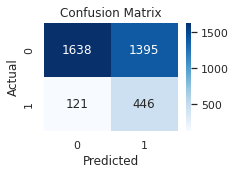

Oversampled dataset(No PCA), ccp_alpha: 0.05 Classification report:
               precision    recall  f1-score   support

         0.0       0.93      0.54      0.68      3033
         1.0       0.24      0.79      0.37       567

    accuracy                           0.58      3600
   macro avg       0.59      0.66      0.53      3600
weighted avg       0.82      0.58      0.63      3600

Evaluating Undersampled dataset(No PCA),ccp_alpha: 0.05...
Undersampled dataset(No PCA),ccp_alpha: 0.05 Accuracy: 0.6338888888888888


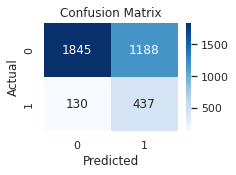

Undersampled dataset(No PCA),ccp_alpha: 0.05 Classification report:
               precision    recall  f1-score   support

         0.0       0.93      0.61      0.74      3033
         1.0       0.27      0.77      0.40       567

    accuracy                           0.63      3600
   macro avg       0.60      0.69      0.57      3600
weighted avg       0.83      0.63      0.68      3600

Evaluating Oversampled dataset(PCA), ccp_alpha: 0.05...
Oversampled dataset(PCA), ccp_alpha: 0.05 Accuracy: 0.6541666666666667


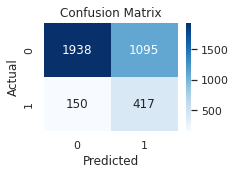

Oversampled dataset(PCA), ccp_alpha: 0.05 Classification report:
               precision    recall  f1-score   support

         0.0       0.93      0.64      0.76      3033
         1.0       0.28      0.74      0.40       567

    accuracy                           0.65      3600
   macro avg       0.60      0.69      0.58      3600
weighted avg       0.83      0.65      0.70      3600

Evaluating Undersampled dataset(PCA), ccp_alpha: 0.05...
Undersampled dataset(PCA), ccp_alpha: 0.05 Accuracy: 0.6580555555555555


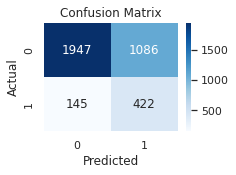

Undersampled dataset(PCA), ccp_alpha: 0.05 Classification report:
               precision    recall  f1-score   support

         0.0       0.93      0.64      0.76      3033
         1.0       0.28      0.74      0.41       567

    accuracy                           0.66      3600
   macro avg       0.61      0.69      0.58      3600
weighted avg       0.83      0.66      0.70      3600



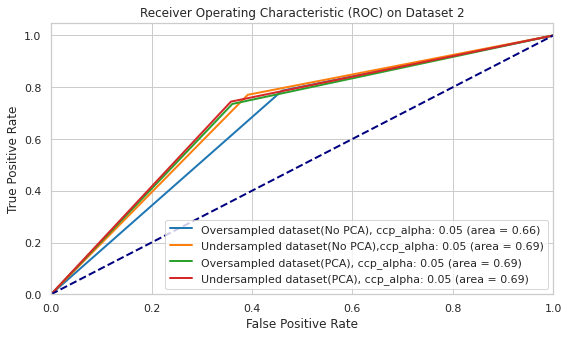

In [55]:
predict(DT_models, DT_name, x_val_list, yval, "validation")

Evaluating testing data 

Evaluating Oversampled dataset(No PCA), ccp_alpha: 0.05...
Oversampled dataset(No PCA), ccp_alpha: 0.05 Accuracy: 0.5776666666666667


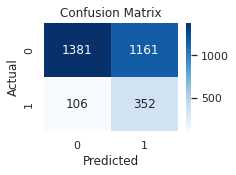

Oversampled dataset(No PCA), ccp_alpha: 0.05 Classification report:
               precision    recall  f1-score   support

         0.0       0.93      0.54      0.69      2542
         1.0       0.23      0.77      0.36       458

    accuracy                           0.58      3000
   macro avg       0.58      0.66      0.52      3000
weighted avg       0.82      0.58      0.64      3000

Evaluating Undersampled dataset(No PCA),ccp_alpha: 0.05...
Undersampled dataset(No PCA),ccp_alpha: 0.05 Accuracy: 0.6396666666666667


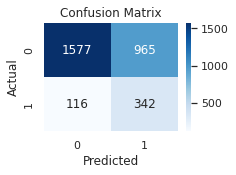

Undersampled dataset(No PCA),ccp_alpha: 0.05 Classification report:
               precision    recall  f1-score   support

         0.0       0.93      0.62      0.74      2542
         1.0       0.26      0.75      0.39       458

    accuracy                           0.64      3000
   macro avg       0.60      0.68      0.57      3000
weighted avg       0.83      0.64      0.69      3000

Evaluating Oversampled dataset(PCA), ccp_alpha: 0.05...
Oversampled dataset(PCA), ccp_alpha: 0.05 Accuracy: 0.6503333333333333


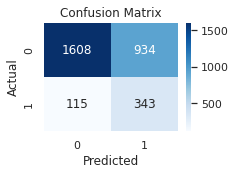

Oversampled dataset(PCA), ccp_alpha: 0.05 Classification report:
               precision    recall  f1-score   support

         0.0       0.93      0.63      0.75      2542
         1.0       0.27      0.75      0.40       458

    accuracy                           0.65      3000
   macro avg       0.60      0.69      0.57      3000
weighted avg       0.83      0.65      0.70      3000

Evaluating Undersampled dataset(PCA), ccp_alpha: 0.05...
Undersampled dataset(PCA), ccp_alpha: 0.05 Accuracy: 0.6586666666666666


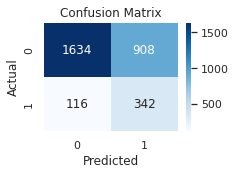

Undersampled dataset(PCA), ccp_alpha: 0.05 Classification report:
               precision    recall  f1-score   support

         0.0       0.93      0.64      0.76      2542
         1.0       0.27      0.75      0.40       458

    accuracy                           0.66      3000
   macro avg       0.60      0.69      0.58      3000
weighted avg       0.83      0.66      0.71      3000



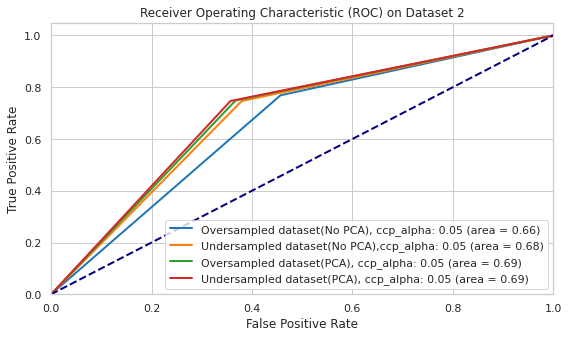

In [56]:
predict(DT_models, DT_name, x_test_list, ytest, "testing")

### Using the oversampled dataset with PCA for hyperparameter tuning because of its high performance

Accuracy Score on train data:  0.6920300113250283


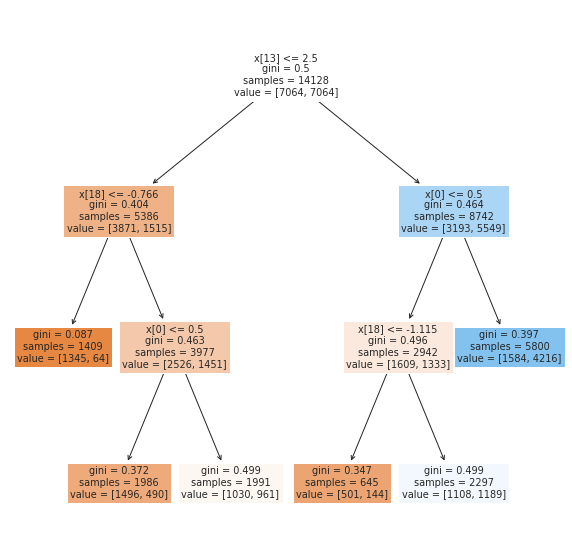

In [57]:
clf_oversampled_pca = DecisionTreeClassifier(random_state=0, ccp_alpha=0.005)

clf_oversampled_pca.fit(xtrain_oversampled, ytrain_oversampled)

y_pred_test_dt_pca = clf_oversampled_pca.predict(xtest)

print('Accuracy Score on train data: ', accuracy_score(y_true=ytrain_oversampled, y_pred=clf_oversampled_pca.predict(xtrain_oversampled)))

DT_models.append(clf_oversampled_pca)
DT_name.append("Oversampled Dataset (No PCA) ccp_alpha: 0.005")
x_test_list.append(xtest)

#plot decision tree
plt.figure(figsize=(10,10))
plot_tree(clf_oversampled_pca, filled=True)
plt.show()

Accuracy Score on train data:  0.6862967157417894


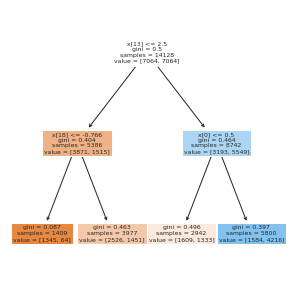

In [58]:
clf_oversampled_pca = DecisionTreeClassifier(random_state=0, ccp_alpha=0.01)

clf_oversampled_pca.fit(xtrain_oversampled, ytrain_oversampled,)

y_pred_test_dt_pca = clf_oversampled_pca.predict(xtest)

print('Accuracy Score on train data: ', accuracy_score(y_true=ytrain_oversampled, y_pred=clf_oversampled_pca.predict(xtrain_oversampled)))

DT_models.append(clf_oversampled_pca)
DT_name.append("Oversampled Dataset ccp_alpha: 0.01")
x_test_list.append(xtest)

#plot decision tree
plt.figure(figsize=(5,5))
plot_tree(clf_oversampled_pca, filled=True)
plt.show()

Evaluating testing data 

Evaluating Oversampled dataset(No PCA), ccp_alpha: 0.05...
Oversampled dataset(No PCA), ccp_alpha: 0.05 Accuracy: 0.5776666666666667


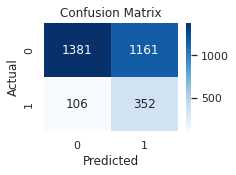

Oversampled dataset(No PCA), ccp_alpha: 0.05 Classification report:
               precision    recall  f1-score   support

         0.0       0.93      0.54      0.69      2542
         1.0       0.23      0.77      0.36       458

    accuracy                           0.58      3000
   macro avg       0.58      0.66      0.52      3000
weighted avg       0.82      0.58      0.64      3000

Evaluating Undersampled dataset(No PCA),ccp_alpha: 0.05...
Undersampled dataset(No PCA),ccp_alpha: 0.05 Accuracy: 0.6396666666666667


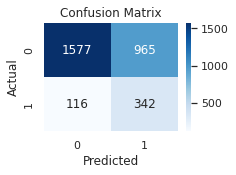

Undersampled dataset(No PCA),ccp_alpha: 0.05 Classification report:
               precision    recall  f1-score   support

         0.0       0.93      0.62      0.74      2542
         1.0       0.26      0.75      0.39       458

    accuracy                           0.64      3000
   macro avg       0.60      0.68      0.57      3000
weighted avg       0.83      0.64      0.69      3000

Evaluating Oversampled dataset(PCA), ccp_alpha: 0.05...
Oversampled dataset(PCA), ccp_alpha: 0.05 Accuracy: 0.6503333333333333


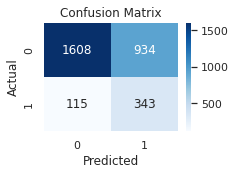

Oversampled dataset(PCA), ccp_alpha: 0.05 Classification report:
               precision    recall  f1-score   support

         0.0       0.93      0.63      0.75      2542
         1.0       0.27      0.75      0.40       458

    accuracy                           0.65      3000
   macro avg       0.60      0.69      0.57      3000
weighted avg       0.83      0.65      0.70      3000

Evaluating Undersampled dataset(PCA), ccp_alpha: 0.05...
Undersampled dataset(PCA), ccp_alpha: 0.05 Accuracy: 0.6586666666666666


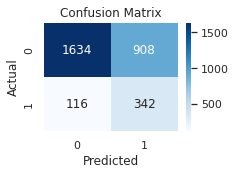

Undersampled dataset(PCA), ccp_alpha: 0.05 Classification report:
               precision    recall  f1-score   support

         0.0       0.93      0.64      0.76      2542
         1.0       0.27      0.75      0.40       458

    accuracy                           0.66      3000
   macro avg       0.60      0.69      0.58      3000
weighted avg       0.83      0.66      0.71      3000

Evaluating Oversampled Dataset (No PCA) ccp_alpha: 0.005...
Oversampled Dataset (No PCA) ccp_alpha: 0.005 Accuracy: 0.6356666666666667


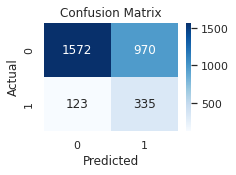

Oversampled Dataset (No PCA) ccp_alpha: 0.005 Classification report:
               precision    recall  f1-score   support

         0.0       0.93      0.62      0.74      2542
         1.0       0.26      0.73      0.38       458

    accuracy                           0.64      3000
   macro avg       0.59      0.67      0.56      3000
weighted avg       0.83      0.64      0.69      3000

Evaluating Oversampled Dataset ccp_alpha: 0.01...
Oversampled Dataset ccp_alpha: 0.01 Accuracy: 0.7566666666666667


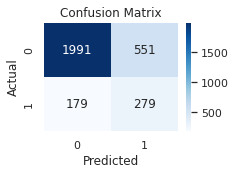

Oversampled Dataset ccp_alpha: 0.01 Classification report:
               precision    recall  f1-score   support

         0.0       0.92      0.78      0.85      2542
         1.0       0.34      0.61      0.43       458

    accuracy                           0.76      3000
   macro avg       0.63      0.70      0.64      3000
weighted avg       0.83      0.76      0.78      3000



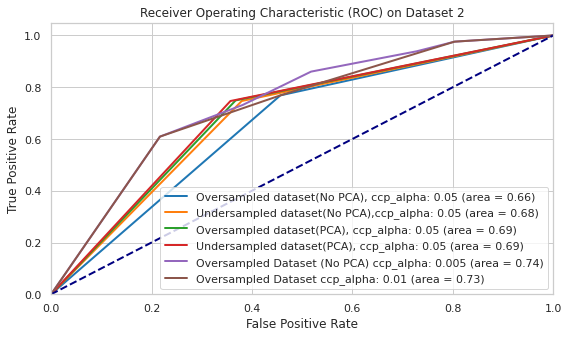

In [59]:
predict(DT_models, DT_name, x_test_list, ytest, "testing")

## Support Vector Machine (SVM)

In [61]:
#list with models, data and names
SVM_models = []
SVM_name = []
x_val_list = []
x_test_list = []

In [62]:
#hyperparameter
gamma=0.05
txt = "gamma: 0.05"

In [63]:
#SVM model - oversampled dataset

#Initialize the SVM classifier
svm_oversampled = svm.SVC(probability=True, random_state=42, gamma=gamma)
SVM_models.append(svm_oversampled)
SVM_name.append(f"Oversampled dataset(No PCA), {txt}")
x_val_list.append(xval)
x_test_list.append(xtest)

#Fit the classifier to the training data
svm_oversampled.fit(xtrain_oversampled, ytrain_oversampled)


SVC(gamma=0.05, probability=True, random_state=42)

In [64]:
#SVM model - undersampled dataset

#Initialize the SVM classifier
svm_undersampled = svm.SVC(probability=True, random_state=42, gamma=gamma)

SVM_models.append(svm_undersampled)
SVM_name.append(f"Undersampled dataset(No PCA), {txt}")
x_val_list.append(xval)
x_test_list.append(xtest)

#Fit the classifier to the training data
svm_undersampled.fit(xtrain_undersampled, ytrain_undersampled)

SVC(gamma=0.05, probability=True, random_state=42)

In [65]:
#SVM model - oversampled dataset

#Initialize the SVM classifier
svm_oversampled_pca = svm.SVC(probability=True, random_state=42, gamma=gamma)

SVM_models.append(svm_oversampled_pca)
SVM_name.append(f"Oversampled dataset(PCA), {txt}")
x_val_list.append(xval_pca_oversampled)
x_test_list.append(xtest_pca_oversampled)

#Fit the classifier to the training data
svm_oversampled_pca.fit(xtrain_pca_oversampled, ytrain_oversampled)

SVC(gamma=0.05, probability=True, random_state=42)

In [66]:
#SVM model - undersampled dataset

# Initialize the SVM classifier
svm_undersampled_pca = svm.SVC(probability=True, random_state=42, gamma=gamma)

SVM_models.append(clf_undersampled_pca)
SVM_name.append(f"Undersampled dataset(PCA), {txt}")
x_val_list.append(xval_pca_undersampled)
x_test_list.append(xtest_pca_undersampled)

#Fit the classifier to the training data
svm_undersampled_pca.fit(xtrain_pca_undersampled, ytrain_undersampled)

SVC(gamma=0.05, probability=True, random_state=42)

Evaluating SVM validation data 

Evaluating Oversampled dataset(No PCA), gamma: 0.05...
Oversampled dataset(No PCA), gamma: 0.05 Accuracy: 0.735


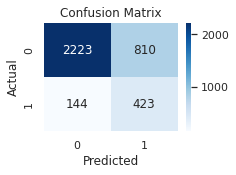

Oversampled dataset(No PCA), gamma: 0.05 Classification report:
               precision    recall  f1-score   support

         0.0       0.94      0.73      0.82      3033
         1.0       0.34      0.75      0.47       567

    accuracy                           0.73      3600
   macro avg       0.64      0.74      0.65      3600
weighted avg       0.85      0.73      0.77      3600

Evaluating Undersampled dataset(No PCA), gamma: 0.05...
Undersampled dataset(No PCA), gamma: 0.05 Accuracy: 0.7047222222222222


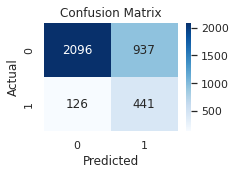

Undersampled dataset(No PCA), gamma: 0.05 Classification report:
               precision    recall  f1-score   support

         0.0       0.94      0.69      0.80      3033
         1.0       0.32      0.78      0.45       567

    accuracy                           0.70      3600
   macro avg       0.63      0.73      0.63      3600
weighted avg       0.85      0.70      0.74      3600

Evaluating Oversampled dataset(PCA), gamma: 0.05...
Oversampled dataset(PCA), gamma: 0.05 Accuracy: 0.7302777777777778


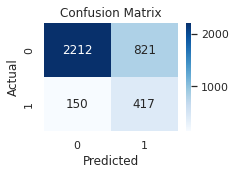

Oversampled dataset(PCA), gamma: 0.05 Classification report:
               precision    recall  f1-score   support

         0.0       0.94      0.73      0.82      3033
         1.0       0.34      0.74      0.46       567

    accuracy                           0.73      3600
   macro avg       0.64      0.73      0.64      3600
weighted avg       0.84      0.73      0.76      3600

Evaluating Undersampled dataset(PCA), gamma: 0.05...
Undersampled dataset(PCA), gamma: 0.05 Accuracy: 0.6580555555555555


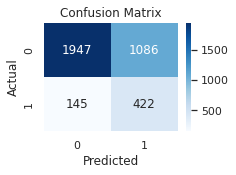

Undersampled dataset(PCA), gamma: 0.05 Classification report:
               precision    recall  f1-score   support

         0.0       0.93      0.64      0.76      3033
         1.0       0.28      0.74      0.41       567

    accuracy                           0.66      3600
   macro avg       0.61      0.69      0.58      3600
weighted avg       0.83      0.66      0.70      3600



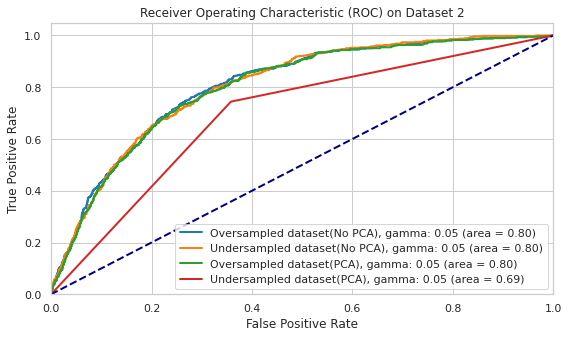

In [67]:
predict(SVM_models, SVM_name, x_val_list, yval, "SVM validation")

Evaluating SVM testing data 

Evaluating Oversampled dataset(No PCA), gamma: 0.05...
Oversampled dataset(No PCA), gamma: 0.05 Accuracy: 0.7246666666666667


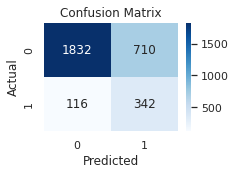

Oversampled dataset(No PCA), gamma: 0.05 Classification report:
               precision    recall  f1-score   support

         0.0       0.94      0.72      0.82      2542
         1.0       0.33      0.75      0.45       458

    accuracy                           0.72      3000
   macro avg       0.63      0.73      0.63      3000
weighted avg       0.85      0.72      0.76      3000

Evaluating Undersampled dataset(No PCA), gamma: 0.05...
Undersampled dataset(No PCA), gamma: 0.05 Accuracy: 0.698


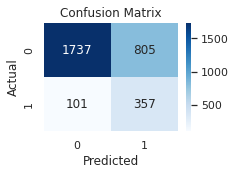

Undersampled dataset(No PCA), gamma: 0.05 Classification report:
               precision    recall  f1-score   support

         0.0       0.95      0.68      0.79      2542
         1.0       0.31      0.78      0.44       458

    accuracy                           0.70      3000
   macro avg       0.63      0.73      0.62      3000
weighted avg       0.85      0.70      0.74      3000

Evaluating Oversampled dataset(PCA), gamma: 0.05...
Oversampled dataset(PCA), gamma: 0.05 Accuracy: 0.7203333333333334


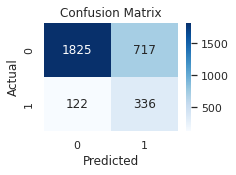

Oversampled dataset(PCA), gamma: 0.05 Classification report:
               precision    recall  f1-score   support

         0.0       0.94      0.72      0.81      2542
         1.0       0.32      0.73      0.44       458

    accuracy                           0.72      3000
   macro avg       0.63      0.73      0.63      3000
weighted avg       0.84      0.72      0.76      3000

Evaluating Undersampled dataset(PCA), gamma: 0.05...
Undersampled dataset(PCA), gamma: 0.05 Accuracy: 0.6586666666666666


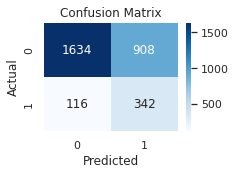

Undersampled dataset(PCA), gamma: 0.05 Classification report:
               precision    recall  f1-score   support

         0.0       0.93      0.64      0.76      2542
         1.0       0.27      0.75      0.40       458

    accuracy                           0.66      3000
   macro avg       0.60      0.69      0.58      3000
weighted avg       0.83      0.66      0.71      3000



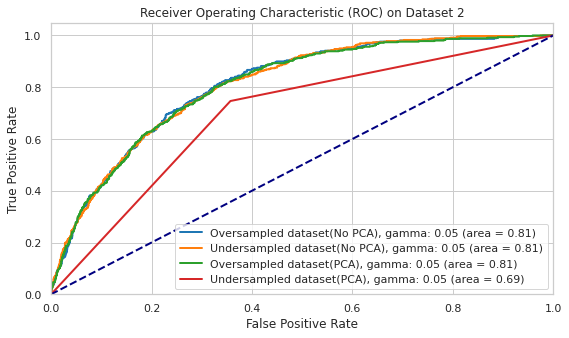

In [68]:
predict(SVM_models, SVM_name, x_test_list, ytest, "SVM testing")

## Multi Layer Perceptron

In [49]:
MLP_models = []
MLP_name = []
x_val_list = []
x_test_list = []

In [50]:
from sklearn.neural_network import MLPClassifier

#Initialize the MLP classifier
mlp_oversampled = MLPClassifier(random_state=42)

MLP_models.append(mlp_oversampled)
MLP_name.append(f"Oversampled dataset(No PCA)")
x_val_list.append(xval)
x_test_list.append(xtest)

#Fit the classifier to the training data
mlp_oversampled.fit(xtrain_oversampled, ytrain_oversampled)


MLPClassifier(random_state=42)

In [51]:
#Initialize the MLP classifier
mlp_undersampled = MLPClassifier(random_state=42)


MLP_models.append(mlp_undersampled)
MLP_name.append(f"Undersampled dataset(No PCA)")
x_val_list.append(xval)
x_test_list.append(xtest)

#Fit the classifier to the training data
mlp_undersampled.fit(xtrain_undersampled, ytrain_undersampled)


MLPClassifier(random_state=42)

In [52]:
#Initialize the MLP classifier
mlp_oversampled_pca = MLPClassifier(random_state=42)

#Append the MLP model to the corresponding lists
MLP_models.append(mlp_oversampled_pca)
MLP_name.append(f"Oversampled dataset(PCA)")
x_val_list.append(xval_pca_oversampled)
x_test_list.append(xtest_pca_oversampled)

#Fit the classifier to the training data
mlp_oversampled_pca.fit(xtrain_pca_oversampled, ytrain_oversampled)


MLPClassifier(random_state=42)

In [53]:
#Initialize the MLP classifier
mlp_undersampled_pca = MLPClassifier(random_state=42)

#Append the MLP model to the corresponding lists
MLP_models.append(mlp_undersampled_pca)
MLP_name.append(f"Undersampled dataset(PCA)")
x_val_list.append(xval_pca_undersampled)
x_test_list.append(xtest_pca_undersampled)

#Fit the classifier to the training data
mlp_undersampled_pca.fit(xtrain_pca_undersampled, ytrain_undersampled)


MLPClassifier(random_state=42)

Evaluating MLP validation data 

Evaluating Oversampled dataset(No PCA)...
Oversampled dataset(No PCA) Accuracy: 0.7813888888888889


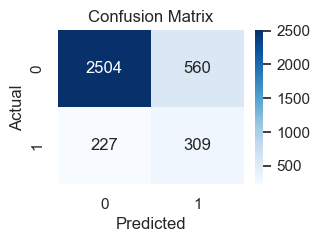

Oversampled dataset(No PCA) Classification report:
               precision    recall  f1-score   support

         0.0       0.92      0.82      0.86      3064
         1.0       0.36      0.58      0.44       536

    accuracy                           0.78      3600
   macro avg       0.64      0.70      0.65      3600
weighted avg       0.83      0.78      0.80      3600

Evaluating Undersampled dataset(No PCA)...
Undersampled dataset(No PCA) Accuracy: 0.6919444444444445


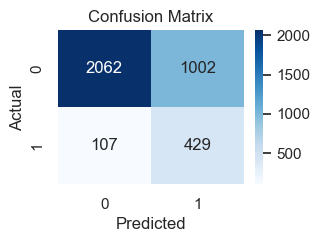

Undersampled dataset(No PCA) Classification report:
               precision    recall  f1-score   support

         0.0       0.95      0.67      0.79      3064
         1.0       0.30      0.80      0.44       536

    accuracy                           0.69      3600
   macro avg       0.63      0.74      0.61      3600
weighted avg       0.85      0.69      0.74      3600

Evaluating Oversampled dataset(PCA)...
Oversampled dataset(PCA) Accuracy: 0.7541666666666667


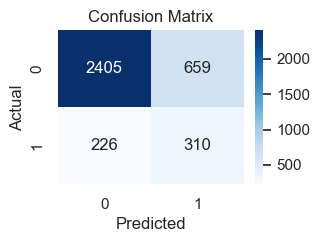

Oversampled dataset(PCA) Classification report:
               precision    recall  f1-score   support

         0.0       0.91      0.78      0.84      3064
         1.0       0.32      0.58      0.41       536

    accuracy                           0.75      3600
   macro avg       0.62      0.68      0.63      3600
weighted avg       0.83      0.75      0.78      3600

Evaluating Undersampled dataset(PCA)...
Undersampled dataset(PCA) Accuracy: 0.6986111111111111


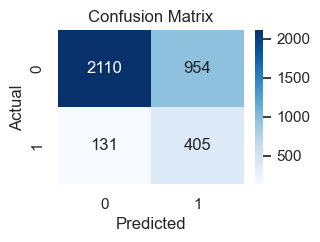

Undersampled dataset(PCA) Classification report:
               precision    recall  f1-score   support

         0.0       0.94      0.69      0.80      3064
         1.0       0.30      0.76      0.43       536

    accuracy                           0.70      3600
   macro avg       0.62      0.72      0.61      3600
weighted avg       0.85      0.70      0.74      3600



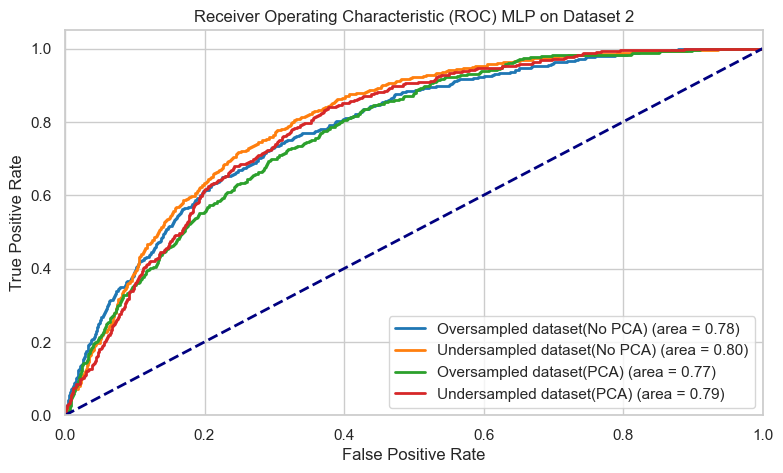

In [54]:
predict(MLP_models, MLP_name, x_val_list, yval, "MLP validation")

Evaluating MLP testing data 

Evaluating Oversampled dataset(No PCA)...
Oversampled dataset(No PCA) Accuracy: 0.773


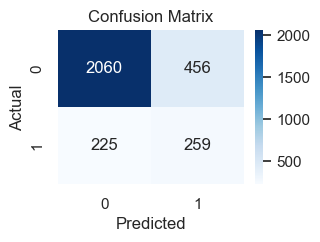

Oversampled dataset(No PCA) Classification report:
               precision    recall  f1-score   support

         0.0       0.90      0.82      0.86      2516
         1.0       0.36      0.54      0.43       484

    accuracy                           0.77      3000
   macro avg       0.63      0.68      0.65      3000
weighted avg       0.81      0.77      0.79      3000

Evaluating Undersampled dataset(No PCA)...
Undersampled dataset(No PCA) Accuracy: 0.674


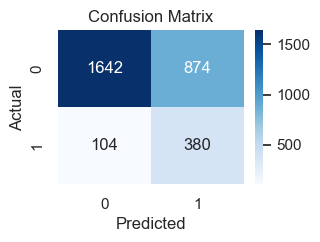

Undersampled dataset(No PCA) Classification report:
               precision    recall  f1-score   support

         0.0       0.94      0.65      0.77      2516
         1.0       0.30      0.79      0.44       484

    accuracy                           0.67      3000
   macro avg       0.62      0.72      0.60      3000
weighted avg       0.84      0.67      0.72      3000

Evaluating Oversampled dataset(PCA)...
Oversampled dataset(PCA) Accuracy: 0.762


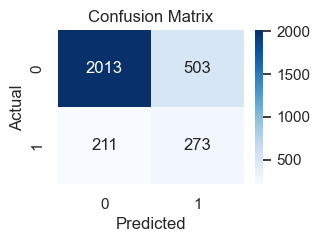

Oversampled dataset(PCA) Classification report:
               precision    recall  f1-score   support

         0.0       0.91      0.80      0.85      2516
         1.0       0.35      0.56      0.43       484

    accuracy                           0.76      3000
   macro avg       0.63      0.68      0.64      3000
weighted avg       0.82      0.76      0.78      3000

Evaluating Undersampled dataset(PCA)...
Undersampled dataset(PCA) Accuracy: 0.688


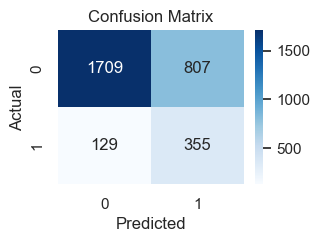

Undersampled dataset(PCA) Classification report:
               precision    recall  f1-score   support

         0.0       0.93      0.68      0.79      2516
         1.0       0.31      0.73      0.43       484

    accuracy                           0.69      3000
   macro avg       0.62      0.71      0.61      3000
weighted avg       0.83      0.69      0.73      3000



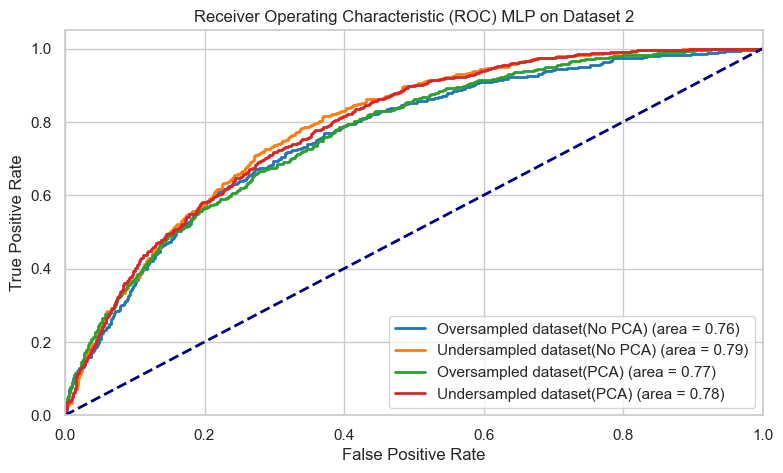

In [55]:
predict(MLP_models, MLP_name, x_test_list, ytest, "MLP testing")

# Cross Validation on Best Performing Datasets

Decision Tree: 0.760333 (0.015908)
SVM: 0.747593 (0.009277)
MLP: 0.824889 (0.010148)


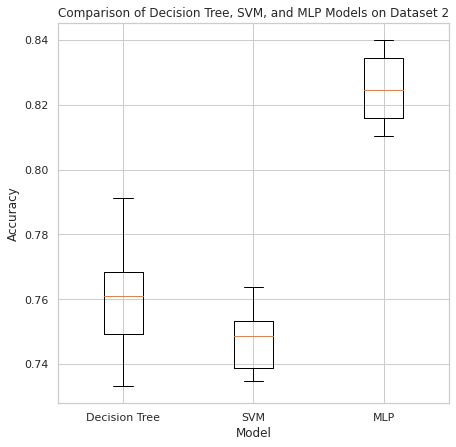

In [77]:
# Define the models
models = [
    ('Decision Tree', DecisionTreeClassifier(ccp_alpha=0.001)),
    ('SVM', SVC(probability=True, random_state=42, gamma=0.01)),
    ('MLP', MLPClassifier(random_state=42))
]

models_list = []
x_val_list = []
x_test_list = []

results = []
names = []
for name, model in models:
    models_list.append(model)
    x_test_list.append(xtest_pca_oversampled)
    kfold = StratifiedKFold(n_splits=10, random_state=None)
    cv_results = cross_val_score(model, xtrain_pca_oversampled, ytrain_oversampled, cv=kfold, scoring='accuracy')
    results.append(cv_results)
    names.append(name)
    print('%s: %f (%f)' % (name, cv_results.mean(), cv_results.std()))

# Compare Algorithms
plt.figure(figsize=(7,7))
plt.boxplot(results, labels=names)
plt.title('Comparison of Decision Tree, SVM, and MLP Models on Dataset 2')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.show()
